In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import PIL.Image
from datetime import datetime
import PIL.ExifTags
from tqdm import tqdm

import dateutil.parser
import os
import re

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, MaxNLocator)

from pyphasechip import pyphasechip_logic as pypc
from typing import Tuple

## Variables

In [2]:
# reagent 1 name
name_sol1 = "BSA"
# reagent 1 starting contentration
initial_conc_sol1 = 3000
# unit
unit_sol1 = "µM"


# reagent 2 name
name_sol2 = "PEG"
# reagent 2 starting concentration
initial_conc_sol2 = 15
# unit
unit_sol2 = "%"


# mixing ratio of the concentrations 0
# [1:X]
initial_ratio = 7


# Number of different concentrations used
number_of_diff_conc = 4

# Number of wells
n_wells = 5

###### delete hoe and iph, use this instead
# total amount of images
total_n_images = 1260
n_timepoints = int(total_n_images / (number_of_diff_conc * n_wells)) 

# percental difference of img mean to all previous imgages. 
# value is similar to a sensivity-value
percental_threshold = 200 #55


# measured diameter of chamber to calculate radii for circle detection -> min and max [px]
# around +-30 of the real value, best measured with something like imageJ/Fiji
diameter = 238 
minRadiusChamber = int((diameter/2)*0.7)
maxRadiusChamber = int((diameter/2)*1.3)


# height of chamber [µm]
chamber_height = 60

# folder where images are stored
# best is to use only paths without any whitespace
#image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\20220601_BSA_PEG_FC40_subset"
image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\20220702_tsf_PEG_subset"

# datatype of the images
extension = ".jpg"

# TODO: use a .yml file for storing these variables

In [ ]:
#THIS IS FOR CELLOBSERVER/ZEISS IMAGES ONLY

def get_sorted_file_list(image_folder: str) -> list:
    files, times, concs, wells = [], [], [], []
    
    for file in os.listdir(image_folder):
        # 1. More robust, faster, but more specific
        c, w, _, t = re.search("c(\d+)_w(\d+)_s(\d+)t(\d+)", file).groups()

        # 2. Other way
        #c, w, _, t, *params = re.findall('[0-9]+', file)
        
        # Generate lists
        times.append(int(t))
        concs.append(int(c))
        wells.append(int(w))
        files.append(file)
        
    return [x for _, _, _, x in sorted(zip(concs, times, wells, files))]
    
get_sorted_file_list(image_folder)

## Programm

In [3]:
# Create all the necessary dicts and lists
image_list, image_names, data_well, well, concentration, time_resolution = pypc.create()

# Load images & convert to grayscale
print("Write images into list")
pypc.images_to_list(image_list, image_names, image_folder, extension)
print("Save them into a dictionary")
pypc.images_to_dict(n_timepoints, number_of_diff_conc, n_wells, image_list, image_names, time_resolution, concentration, well, data_well)

# Two possibilities:
# use script if you did a pipetting series
starting_concentrations = pypc.starting_concentration(initial_conc_sol1, initial_conc_sol2, initial_ratio)
# or
# write list
#starting_concentrations = np.array(([40, 9.5], [200, 7.2], [530, 4], [2800, 1.7]))  # BSA Test set
starting_concentrations = np.array(([9.4, 88.6], [21.2, 74.3], [44.8, 45.7], [56.6, 31.4]))

print("Analyse data...")
well_nr = 0
for conc_nr in range(number_of_diff_conc): # for n_rows_per_conc in range(2):
    
    for n_wells_per_row in range(n_wells):

        # Initialise variables, arrays and lists
        well_data = np.zeros(shape=(2, 3))
        threshed_img = np.zeros(shape=time_resolution[0][0][0]['gray'].shape, dtype="uint8")
        areas = np.zeros(shape=(1, 2))
        droplet_arr = np.zeros(shape=(2,4))
        mean_list = []
        llps_status = False
        n_0 = 0
        multiple_droplets = None
        multiple_droplets_count = 0

        print("conc:", conc_nr, "well:", well_nr)
        for time_idx in tqdm(range(n_timepoints)): #n_timepoints
            if llps_status is False:
                #print("---", "C:", conc_nr, "W:", well_nr, " T:", time_idx, "---")

                image = time_resolution[time_idx][conc_nr][well_nr]['gray'].copy()

                x, y, r, droplet_data, droplet_found, multiple_droplets_count, masked_img, grad2, well_data = pypc.droplet_detection(image, well_data, diameter, llps_status,
                                                                                                                                     multiple_droplets_count, droplet_arr, time_idx, conc_nr, well_nr)

                time_resolution[time_idx][conc_nr][well_nr]['img'] = masked_img
                time_resolution[time_idx][conc_nr][well_nr]['grad2'] = grad2
                time_resolution[time_idx][conc_nr][well_nr]['manipulated img'] = grad2 # needed for display
                time_resolution[time_idx][conc_nr][well_nr]['droplet data'] = droplet_arr.copy()
                time_resolution[time_idx][conc_nr][well_nr]['x'] = x # needed for display
                time_resolution[time_idx][conc_nr][well_nr]['y'] = y # needed for display
                time_resolution[time_idx][conc_nr][well_nr]['r'] = well_data[0, 2] # needed for display
                time_resolution[0][conc_nr][well_nr]['multiple droplets'] = multiple_droplets_count

                # save first area
                if time_idx == 0:
                    areas[0, 0] = droplet_arr[0, 3]

                llps_status, areas, mean_list, droplet_arr, squi, cro_squi, n_0 = pypc.detect_LLPS(percental_threshold, droplet_arr, llps_status, image, time_idx, areas, mean_list, droplet_found, n_0)
                                                                                                                                                # masked_img
                # if noise is too high, ignore droplet
                # later: change "multiplet droplets" to "ignore well"
                if n_0 > 400:
                    multiple_droplets = True
                    time_resolution[0][conc_nr][well_nr]['multiple droplets'] = multiple_droplets


                time_resolution[0][conc_nr][well_nr]['areas'] = areas
                time_resolution[0][conc_nr][well_nr]['mean list'] = mean_list
                time_resolution[time_idx][conc_nr][well_nr]['squ'] = squi
                time_resolution[time_idx][conc_nr][well_nr]['cro squ'] = cro_squi

                time_resolution[time_idx][conc_nr][well_nr]['droplet array'] = droplet_arr


                if llps_status is True:
                    print("LLPS status: ", llps_status, ", @", "c:", conc_nr, "w:", well_nr, "t:", time_idx)
                    # save img time where llps was found
                    time_resolution[0][conc_nr][well_nr]['time idx'] = time_idx
                    # save name of image where LLPS was detected
                    time_resolution[0][conc_nr][well_nr]['LLPS name'] = time_resolution[time_idx][conc_nr][well_nr]['name']
                    # calculate the critical concentration
                    llps_conc = pypc.ccrit_calculation(starting_concentrations, areas, conc_nr)
                    time_resolution[0][conc_nr][well_nr]['LLPS conc'] = llps_conc

        well_nr += 1
    well_nr = 0

# saves the image names where LLPS was detected and the calculated concentrations to a csv file
# .csv gets safed in the image folder
#pypc.save_results_to_csv(time_resolution, image_folder, number_of_diff_conc, n_wells, hours_of_experiment,
#                       images_per_hour, name_sol1, name_sol2, unit_sol1, unit_sol2)

Write images into list


100%|█████████████████████████████████████████████████████████████████████████████| 1260/1260 [00:09<00:00, 137.94it/s]


Save them into a dictionary


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

Analyse data...
conc: 0 well: 0
multiple_droplets: n = 141
status: 0,0,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 338,151,45
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:50,  1.22it/s]

multiple_droplets: n = 225
status: 0,0,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 383,209,109
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:50,  1.21it/s]

multiple_droplets: n = 233
status: 0,0,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,241,82
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:49,  1.22it/s]

multiple_droplets: n = 241
status: 0,0,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 425,206,110
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:48,  1.21it/s]

multiple_droplets: n = 203
status: 0,0,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 415,196,86
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:47,  1.22it/s]

multiple_droplets: n = 204
status: 0,0,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 422,210,99
status: droplet_found: True


 10%|███████▉                                                                           | 6/63 [00:04<00:46,  1.22it/s]

status: 0,0,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 426,210,95
status: droplet_found: True


 11%|█████████▏                                                                         | 7/63 [00:05<00:44,  1.25it/s]

status: 0,0,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,217,92
status: droplet_found: True


 13%|██████████▌                                                                        | 8/63 [00:06<00:43,  1.27it/s]

status: 0,0,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,218,89
status: droplet_found: True


 14%|███████████▊                                                                       | 9/63 [00:07<00:41,  1.29it/s]

status: 0,0,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,220,89
status: droplet_found: True


 16%|█████████████                                                                     | 10/63 [00:07<00:40,  1.31it/s]

status: 0,0,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,226,84
status: droplet_found: True


 17%|██████████████▎                                                                   | 11/63 [00:08<00:39,  1.32it/s]

status: 0,0,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 409,220,81
status: droplet_found: True


 19%|███████████████▌                                                                  | 12/63 [00:09<00:38,  1.33it/s]

status: 0,0,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,223,84
status: droplet_found: True


 21%|████████████████▉                                                                 | 13/63 [00:10<00:37,  1.33it/s]

status: 0,0,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,223,83
status: droplet_found: True


 22%|██████████████████▏                                                               | 14/63 [00:10<00:36,  1.34it/s]

status: 0,0,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 407,225,76
status: droplet_found: True


 24%|███████████████████▌                                                              | 15/63 [00:11<00:35,  1.34it/s]

status: 0,0,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,217,76
status: droplet_found: True


 25%|████████████████████▊                                                             | 16/63 [00:12<00:34,  1.35it/s]

status: 0,0,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 412,225,76
status: droplet_found: True


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.35it/s]

status: 0,0,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,230,73
status: droplet_found: True


 29%|███████████████████████▍                                                          | 18/63 [00:13<00:33,  1.35it/s]

status: 0,0,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,225,73
status: droplet_found: True


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:32,  1.35it/s]

status: 0,0,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,220,67
status: droplet_found: True


 32%|██████████████████████████                                                        | 20/63 [00:15<00:31,  1.35it/s]

status: 0,0,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,222,69
status: droplet_found: True


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.35it/s]

status: 0,0,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,218,65
status: droplet_found: True


 35%|████████████████████████████▋                                                     | 22/63 [00:16<00:30,  1.35it/s]

status: 0,0,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 422,226,64
status: droplet_found: True


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:29,  1.35it/s]

status: 0,0,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 422,220,64
status: droplet_found: True


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:28,  1.35it/s]

status: 0,0,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,217,60
status: droplet_found: True


 40%|████████████████████████████████▌                                                 | 25/63 [00:19<00:28,  1.35it/s]

status: 0,0,25: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,220,60
status: droplet_found: True


 41%|█████████████████████████████████▊                                                | 26/63 [00:19<00:27,  1.36it/s]

status: 0,0,26: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,218,60
status: droplet_found: True


 43%|███████████████████████████████████▏                                              | 27/63 [00:20<00:26,  1.35it/s]

status: 0,0,27: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 420,222,55
status: droplet_found: True


 44%|████████████████████████████████████▍                                             | 28/63 [00:21<00:25,  1.36it/s]

status: 0,0,28: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,220,53
status: droplet_found: True


 46%|█████████████████████████████████████▋                                            | 29/63 [00:21<00:24,  1.37it/s]

status: 0,0,29: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,218,50
status: droplet_found: True


 48%|███████████████████████████████████████                                           | 30/63 [00:22<00:24,  1.36it/s]

status: 0,0,30: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 415,215,52
status: droplet_found: True


 49%|████████████████████████████████████████▎                                         | 31/63 [00:23<00:23,  1.37it/s]

status: 0,0,31: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,218,46
status: droplet_found: True


 51%|█████████████████████████████████████████▋                                        | 32/63 [00:24<00:22,  1.37it/s]

status: 0,0,32: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 420,217,47
status: droplet_found: True


 52%|██████████████████████████████████████████▉                                       | 33/63 [00:24<00:21,  1.38it/s]

status: 0,0,33: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,215,48
status: droplet_found: True


 54%|████████████████████████████████████████████▎                                     | 34/63 [00:25<00:21,  1.37it/s]

status: 0,0,34: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 422,217,45
status: droplet_found: True


 56%|█████████████████████████████████████████████▌                                    | 35/63 [00:26<00:20,  1.38it/s]

status: 0,0,35: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,212,44
status: droplet_found: True


 57%|██████████████████████████████████████████████▊                                   | 36/63 [00:27<00:19,  1.38it/s]

status: 0,0,36: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,218,42
status: droplet_found: True


 59%|████████████████████████████████████████████████▏                                 | 37/63 [00:27<00:18,  1.38it/s]

status: 0,0,37: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 422,217,39
status: droplet_found: True


 60%|█████████████████████████████████████████████████▍                                | 38/63 [00:28<00:18,  1.37it/s]

status: 0,0,38: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 415,215,42
status: droplet_found: True


 62%|██████████████████████████████████████████████████▊                               | 39/63 [00:29<00:17,  1.37it/s]

status: 0,0,39: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,214,34
status: droplet_found: True


 63%|████████████████████████████████████████████████████                              | 40/63 [00:30<00:16,  1.35it/s]

status: 0,0,40: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,215,33
status: droplet_found: True


 65%|█████████████████████████████████████████████████████▎                            | 41/63 [00:30<00:16,  1.36it/s]

status: 0,0,41: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,210,33
status: droplet_found: True


 67%|██████████████████████████████████████████████████████▋                           | 42/63 [00:31<00:15,  1.37it/s]

status: 0,0,42: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,214,35
status: droplet_found: True


 68%|███████████████████████████████████████████████████████▉                          | 43/63 [00:32<00:14,  1.37it/s]

status: 0,0,43: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 406,206,27
status: droplet_found: True


 70%|█████████████████████████████████████████████████████████▎                        | 44/63 [00:32<00:13,  1.37it/s]

status: 0,0,44: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,207,21
status: droplet_found: True


 71%|██████████████████████████████████████████████████████████▌                       | 45/63 [00:33<00:13,  1.37it/s]

status: 0,0,45: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,206,30
status: droplet_found: True


 73%|███████████████████████████████████████████████████████████▊                      | 46/63 [00:34<00:12,  1.38it/s]

status: 0,0,46: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 402,199,15
status: droplet_found: True


 75%|█████████████████████████████████████████████████████████████▏                    | 47/63 [00:35<00:11,  1.38it/s]

status: 0,0,47: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,209,23
status: droplet_found: True


 76%|██████████████████████████████████████████████████████████████▍                   | 48/63 [00:35<00:10,  1.38it/s]

status: 0,0,48: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,202,26
status: droplet_found: True


 78%|███████████████████████████████████████████████████████████████▊                  | 49/63 [00:36<00:10,  1.38it/s]

status: 0,0,49: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 412,209,18
status: droplet_found: True


 79%|█████████████████████████████████████████████████████████████████                 | 50/63 [00:37<00:09,  1.38it/s]

status: 0,0,50: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 310,217,12
status: droplet_found: True


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 0 t: 50
conc: 0 well: 1
multiple_droplets: n = 0
status: 0,1,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:52,  1.17it/s]

multiple_droplets: n = 0
status: 0,1,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:52,  1.17it/s]

multiple_droplets: n = 2
status: 0,1,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:50,  1.18it/s]

multiple_droplets: n = 4
status: 0,1,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:51,  1.16it/s]

multiple_droplets: n = 2
status: 0,1,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:49,  1.17it/s]

multiple_droplets: n = 0
status: 0,1,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 10%|███████▉                                                                           | 6/63 [00:05<00:47,  1.20it/s]

status: 0,1,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 11%|█████████▏                                                                         | 7/63 [00:05<00:45,  1.24it/s]

status: 0,1,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 13%|██████████▌                                                                        | 8/63 [00:06<00:43,  1.27it/s]

status: 0,1,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 14%|███████████▊                                                                       | 9/63 [00:07<00:42,  1.29it/s]

status: 0,1,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 16%|█████████████                                                                     | 10/63 [00:08<00:40,  1.30it/s]

status: 0,1,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 17%|██████████████▎                                                                   | 11/63 [00:08<00:39,  1.31it/s]

status: 0,1,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 401,284,83
status: droplet_found: True


 19%|███████████████▌                                                                  | 12/63 [00:09<00:38,  1.31it/s]

status: 0,1,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 412,282,89
status: droplet_found: True


 21%|████████████████▉                                                                 | 13/63 [00:10<00:37,  1.32it/s]

status: 0,1,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 412,276,87
status: droplet_found: True


 22%|██████████████████▏                                                               | 14/63 [00:11<00:37,  1.32it/s]

status: 0,1,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,281,85
status: droplet_found: True


 24%|███████████████████▌                                                              | 15/63 [00:11<00:36,  1.33it/s]

status: 0,1,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 412,276,84
status: droplet_found: True


 25%|████████████████████▊                                                             | 16/63 [00:12<00:35,  1.33it/s]

status: 0,1,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 409,282,85
status: droplet_found: True


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.34it/s]

status: 0,1,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,287,80
status: droplet_found: True


 29%|███████████████████████▍                                                          | 18/63 [00:14<00:33,  1.34it/s]

status: 0,1,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,286,80
status: droplet_found: True


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:32,  1.34it/s]

status: 0,1,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 409,281,76
status: droplet_found: True


 32%|██████████████████████████                                                        | 20/63 [00:15<00:31,  1.35it/s]

status: 0,1,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 415,292,76
status: droplet_found: True


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.35it/s]

status: 0,1,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 409,286,72
status: droplet_found: True


 35%|████████████████████████████▋                                                     | 22/63 [00:17<00:30,  1.34it/s]

status: 0,1,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 415,292,73
status: droplet_found: True


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:29,  1.35it/s]

status: 0,1,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 415,294,71
status: droplet_found: True


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:28,  1.35it/s]

status: 0,1,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,286,66
status: droplet_found: True


 40%|████████████████████████████████▌                                                 | 25/63 [00:19<00:27,  1.36it/s]

status: 0,1,25: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,292,65
status: droplet_found: True


 41%|█████████████████████████████████▊                                                | 26/63 [00:19<00:27,  1.36it/s]

status: 0,1,26: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,292,66
status: droplet_found: True


 43%|███████████████████████████████████▏                                              | 27/63 [00:20<00:26,  1.35it/s]

status: 0,1,27: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,289,62
status: droplet_found: True


 44%|████████████████████████████████████▍                                             | 28/63 [00:21<00:25,  1.36it/s]

status: 0,1,28: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 412,290,59
status: droplet_found: True


 46%|█████████████████████████████████████▋                                            | 29/63 [00:22<00:25,  1.34it/s]

status: 0,1,29: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 420,289,59
status: droplet_found: True


 48%|███████████████████████████████████████                                           | 30/63 [00:22<00:24,  1.35it/s]

status: 0,1,30: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,297,60
status: droplet_found: True


 49%|████████████████████████████████████████▎                                         | 31/63 [00:23<00:23,  1.35it/s]

status: 0,1,31: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,297,53
status: droplet_found: True


 51%|█████████████████████████████████████████▋                                        | 32/63 [00:24<00:23,  1.34it/s]

status: 0,1,32: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,294,51
status: droplet_found: True


 52%|██████████████████████████████████████████▉                                       | 33/63 [00:25<00:22,  1.34it/s]

status: 0,1,33: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 415,295,55
status: droplet_found: True


 54%|████████████████████████████████████████████▎                                     | 34/63 [00:25<00:21,  1.35it/s]

status: 0,1,34: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,290,52
status: droplet_found: True


 56%|█████████████████████████████████████████████▌                                    | 35/63 [00:26<00:20,  1.35it/s]

status: 0,1,35: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,290,50
status: droplet_found: True


 57%|██████████████████████████████████████████████▊                                   | 36/63 [00:27<00:19,  1.36it/s]

status: 0,1,36: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,298,48
status: droplet_found: True


 59%|████████████████████████████████████████████████▏                                 | 37/63 [00:28<00:19,  1.37it/s]

status: 0,1,37: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,294,48
status: droplet_found: True


 60%|█████████████████████████████████████████████████▍                                | 38/63 [00:28<00:18,  1.35it/s]

status: 0,1,38: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,294,44
status: droplet_found: True


 62%|██████████████████████████████████████████████████▊                               | 39/63 [00:29<00:17,  1.36it/s]

status: 0,1,39: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 409,294,47
status: droplet_found: True


 63%|████████████████████████████████████████████████████                              | 40/63 [00:30<00:17,  1.35it/s]

status: 0,1,40: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 404,311,29
status: droplet_found: True


 65%|█████████████████████████████████████████████████████▎                            | 41/63 [00:31<00:16,  1.36it/s]

status: 0,1,41: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 406,287,41
status: droplet_found: True


C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\pythonProject\PyPhaseChip\pyphasechip\pyphasechip_fun.py:284: RuntimeWarning: divide by zero encountered in double_scalars
  percental_difference = (mean_abs / avg_mean_all_previous_images) * 100 - 100
  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 1 t: 41
conc: 0 well: 2
multiple_droplets: n = 2
status: 0,2,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 385,278,118
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:51,  1.22it/s]

multiple_droplets: n = 2
status: 0,2,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 396,287,115
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:50,  1.21it/s]

multiple_droplets: n = 0
status: 0,2,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 393,279,113
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:50,  1.19it/s]

multiple_droplets: n = 0
status: 0,2,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 396,289,110
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:49,  1.19it/s]

multiple_droplets: n = 2
status: 0,2,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 404,286,112
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:48,  1.20it/s]

multiple_droplets: n = 2
status: 0,2,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 402,294,105
status: droplet_found: True


 10%|███████▉                                                                           | 6/63 [00:05<00:47,  1.20it/s]

status: 0,2,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 409,292,108
status: droplet_found: True


 11%|█████████▏                                                                         | 7/63 [00:05<00:45,  1.23it/s]

status: 0,2,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 406,300,104
status: droplet_found: True


 13%|██████████▌                                                                        | 8/63 [00:06<00:43,  1.26it/s]

status: 0,2,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 407,292,103
status: droplet_found: True


 14%|███████████▊                                                                       | 9/63 [00:07<00:42,  1.27it/s]

status: 0,2,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 406,294,96
status: droplet_found: True


 16%|█████████████                                                                     | 10/63 [00:08<00:41,  1.29it/s]

status: 0,2,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 409,292,99
status: droplet_found: True


 17%|██████████████▎                                                                   | 11/63 [00:08<00:40,  1.30it/s]

status: 0,2,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 407,292,93
status: droplet_found: True


 19%|███████████████▌                                                                  | 12/63 [00:09<00:39,  1.31it/s]

status: 0,2,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 412,298,92
status: droplet_found: True


 21%|████████████████▉                                                                 | 13/63 [00:10<00:38,  1.31it/s]

status: 0,2,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,297,92
status: droplet_found: True


 22%|██████████████████▏                                                               | 14/63 [00:11<00:37,  1.32it/s]

status: 0,2,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,297,85
status: droplet_found: True


 24%|███████████████████▌                                                              | 15/63 [00:11<00:36,  1.32it/s]

status: 0,2,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 409,297,86
status: droplet_found: True


 25%|████████████████████▊                                                             | 16/63 [00:12<00:35,  1.33it/s]

status: 0,2,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 409,297,83
status: droplet_found: True


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.34it/s]

status: 0,2,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 412,300,82
status: droplet_found: True


 29%|███████████████████████▍                                                          | 18/63 [00:14<00:33,  1.34it/s]

status: 0,2,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 412,303,78
status: droplet_found: True


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:32,  1.35it/s]

status: 0,2,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,302,81
status: droplet_found: True


 32%|██████████████████████████                                                        | 20/63 [00:15<00:31,  1.35it/s]

status: 0,2,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,302,78
status: droplet_found: True


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.35it/s]

status: 0,2,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,303,77
status: droplet_found: True


 35%|████████████████████████████▋                                                     | 22/63 [00:17<00:30,  1.34it/s]

status: 0,2,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,305,69
status: droplet_found: True


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:29,  1.35it/s]

status: 0,2,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 420,302,73
status: droplet_found: True


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:28,  1.35it/s]

status: 0,2,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 415,305,71
status: droplet_found: True


 40%|████████████████████████████████▌                                                 | 25/63 [00:19<00:28,  1.35it/s]

status: 0,2,25: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 420,310,66
status: droplet_found: True


 41%|█████████████████████████████████▊                                                | 26/63 [00:19<00:27,  1.35it/s]

status: 0,2,26: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,303,69
status: droplet_found: True


 43%|███████████████████████████████████▏                                              | 27/63 [00:20<00:26,  1.34it/s]

status: 0,2,27: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 423,306,66
status: droplet_found: True


 44%|████████████████████████████████████▍                                             | 28/63 [00:21<00:26,  1.34it/s]

status: 0,2,28: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,302,64
status: droplet_found: True


 46%|█████████████████████████████████████▋                                            | 29/63 [00:22<00:25,  1.35it/s]

status: 0,2,29: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 425,302,57
status: droplet_found: True


 48%|███████████████████████████████████████                                           | 30/63 [00:22<00:24,  1.35it/s]

status: 0,2,30: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,302,61
status: droplet_found: True


 49%|████████████████████████████████████████▎                                         | 31/63 [00:23<00:23,  1.35it/s]

status: 0,2,31: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,298,53
status: droplet_found: True


 51%|█████████████████████████████████████████▋                                        | 32/63 [00:24<00:23,  1.34it/s]

status: 0,2,32: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,298,51
status: droplet_found: True


 52%|██████████████████████████████████████████▉                                       | 33/63 [00:25<00:22,  1.35it/s]

status: 0,2,33: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,302,57
status: droplet_found: True


 54%|████████████████████████████████████████████▎                                     | 34/63 [00:25<00:21,  1.35it/s]

status: 0,2,34: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 422,297,55
status: droplet_found: True


 56%|█████████████████████████████████████████████▌                                    | 35/63 [00:26<00:20,  1.35it/s]

status: 0,2,35: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,302,53
status: droplet_found: True


 57%|██████████████████████████████████████████████▊                                   | 36/63 [00:27<00:19,  1.36it/s]

status: 0,2,36: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 420,303,47
status: droplet_found: True


 59%|████████████████████████████████████████████████▏                                 | 37/63 [00:28<00:19,  1.36it/s]

status: 0,2,37: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 425,302,47
status: droplet_found: True


 60%|█████████████████████████████████████████████████▍                                | 38/63 [00:28<00:18,  1.36it/s]

status: 0,2,38: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 422,302,42
status: droplet_found: True


 62%|██████████████████████████████████████████████████▊                               | 39/63 [00:29<00:17,  1.37it/s]

status: 0,2,39: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,298,48
status: droplet_found: True


 63%|████████████████████████████████████████████████████                              | 40/63 [00:30<00:17,  1.34it/s]

status: 0,2,40: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 422,298,39
status: droplet_found: True


 65%|█████████████████████████████████████████████████████▎                            | 41/63 [00:31<00:16,  1.35it/s]

status: 0,2,41: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 401,294,21
status: droplet_found: True


 67%|██████████████████████████████████████████████████████▋                           | 42/63 [00:31<00:15,  1.36it/s]

status: 0,2,42: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,302,35
status: droplet_found: True


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 2 t: 42
conc: 0 well: 3
multiple_droplets: n = 2
status: 0,3,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:51,  1.20it/s]

multiple_droplets: n = 2
status: 0,3,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:51,  1.18it/s]

multiple_droplets: n = 2
status: 0,3,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:50,  1.19it/s]

multiple_droplets: n = 2
status: 0,3,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:50,  1.18it/s]

multiple_droplets: n = 0
status: 0,3,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:49,  1.18it/s]

multiple_droplets: n = 2
status: 0,3,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 10%|███████▉                                                                           | 6/63 [00:05<00:47,  1.20it/s]

status: 0,3,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 409,318,107
status: droplet_found: True


 11%|█████████▏                                                                         | 7/63 [00:05<00:45,  1.23it/s]

status: 0,3,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 402,326,94
status: droplet_found: True


 13%|██████████▌                                                                        | 8/63 [00:06<00:43,  1.26it/s]

status: 0,3,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 415,316,108
status: droplet_found: True


 14%|███████████▊                                                                       | 9/63 [00:07<00:42,  1.27it/s]

status: 0,3,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,324,94
status: droplet_found: True


 16%|█████████████                                                                     | 10/63 [00:08<00:41,  1.29it/s]

status: 0,3,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,326,97
status: droplet_found: True


 17%|██████████████▎                                                                   | 11/63 [00:08<00:40,  1.30it/s]

status: 0,3,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 412,324,92
status: droplet_found: True


 19%|███████████████▌                                                                  | 12/63 [00:09<00:38,  1.31it/s]

status: 0,3,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,326,93
status: droplet_found: True


 21%|████████████████▉                                                                 | 13/63 [00:10<00:38,  1.31it/s]

status: 0,3,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 422,329,87
status: droplet_found: True


 22%|██████████████████▏                                                               | 14/63 [00:11<00:37,  1.31it/s]

status: 0,3,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 423,324,87
status: droplet_found: True


 24%|███████████████████▌                                                              | 15/63 [00:11<00:36,  1.32it/s]

status: 0,3,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 423,329,84
status: droplet_found: True


 25%|████████████████████▊                                                             | 16/63 [00:12<00:35,  1.32it/s]

status: 0,3,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 422,322,81
status: droplet_found: True


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.33it/s]

status: 0,3,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 423,332,81
status: droplet_found: True


 29%|███████████████████████▍                                                          | 18/63 [00:14<00:33,  1.34it/s]

status: 0,3,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 430,326,79
status: droplet_found: True


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:33,  1.33it/s]

status: 0,3,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 430,334,80
status: droplet_found: True


 32%|██████████████████████████                                                        | 20/63 [00:15<00:32,  1.34it/s]

status: 0,3,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 433,329,77
status: droplet_found: True


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.34it/s]

status: 0,3,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 428,329,74
status: droplet_found: True


 35%|████████████████████████████▋                                                     | 22/63 [00:17<00:30,  1.35it/s]

status: 0,3,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 433,337,74
status: droplet_found: True


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:29,  1.34it/s]

status: 0,3,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 438,329,69
status: droplet_found: True


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:28,  1.35it/s]

status: 0,3,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 430,338,69
status: droplet_found: True


 40%|████████████████████████████████▌                                                 | 25/63 [00:19<00:28,  1.35it/s]

status: 0,3,25: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 430,345,66
status: droplet_found: True


 41%|█████████████████████████████████▊                                                | 26/63 [00:20<00:27,  1.35it/s]

status: 0,3,26: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 431,342,66
status: droplet_found: True


 43%|███████████████████████████████████▏                                              | 27/63 [00:20<00:26,  1.36it/s]

status: 0,3,27: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 438,346,63
status: droplet_found: True


 44%|████████████████████████████████████▍                                             | 28/63 [00:21<00:25,  1.36it/s]

status: 0,3,28: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 431,342,58
status: droplet_found: True


 46%|█████████████████████████████████████▋                                            | 29/63 [00:22<00:25,  1.34it/s]

status: 0,3,29: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 433,345,59
status: droplet_found: True


 48%|███████████████████████████████████████                                           | 30/63 [00:23<00:24,  1.34it/s]

status: 0,3,30: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 431,345,59
status: droplet_found: True


 49%|████████████████████████████████████████▎                                         | 31/63 [00:23<00:23,  1.35it/s]

status: 0,3,31: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 430,345,59
status: droplet_found: True


 51%|█████████████████████████████████████████▋                                        | 32/63 [00:24<00:22,  1.35it/s]

status: 0,3,32: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 433,345,53
status: droplet_found: True


 52%|██████████████████████████████████████████▉                                       | 33/63 [00:25<00:22,  1.35it/s]

status: 0,3,33: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 434,346,50
status: droplet_found: True


 54%|████████████████████████████████████████████▎                                     | 34/63 [00:25<00:21,  1.35it/s]

status: 0,3,34: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 438,345,52
status: droplet_found: True


 56%|█████████████████████████████████████████████▌                                    | 35/63 [00:26<00:20,  1.35it/s]

status: 0,3,35: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 434,346,47
status: droplet_found: True


 57%|██████████████████████████████████████████████▊                                   | 36/63 [00:27<00:19,  1.35it/s]

status: 0,3,36: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 433,350,50
status: droplet_found: True


 59%|████████████████████████████████████████████████▏                                 | 37/63 [00:28<00:19,  1.36it/s]

status: 0,3,37: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 438,345,49
status: droplet_found: True


 60%|█████████████████████████████████████████████████▍                                | 38/63 [00:28<00:18,  1.36it/s]

status: 0,3,38: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 434,351,44
status: droplet_found: True


 62%|██████████████████████████████████████████████████▊                               | 39/63 [00:29<00:17,  1.37it/s]

status: 0,3,39: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 431,350,40
status: droplet_found: True


 63%|████████████████████████████████████████████████████                              | 40/63 [00:30<00:16,  1.37it/s]

status: 0,3,40: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 436,351,41
status: droplet_found: True


 65%|█████████████████████████████████████████████████████▎                            | 41/63 [00:31<00:16,  1.37it/s]

status: 0,3,41: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 431,353,42
status: droplet_found: True


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 3 t: 41
conc: 0 well: 4
multiple_droplets: n = 2
status: 0,4,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:51,  1.20it/s]

multiple_droplets: n = 0
status: 0,4,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:51,  1.19it/s]

multiple_droplets: n = 3
status: 0,4,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:50,  1.18it/s]

multiple_droplets: n = 2
status: 0,4,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:49,  1.18it/s]

multiple_droplets: n = 0
status: 0,4,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:49,  1.18it/s]

multiple_droplets: n = 8
status: 0,4,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 10%|███████▉                                                                           | 6/63 [00:05<00:47,  1.20it/s]

status: 0,4,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 391,353,96
status: droplet_found: True


 11%|█████████▏                                                                         | 7/63 [00:05<00:44,  1.25it/s]

status: 0,4,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 394,348,97
status: droplet_found: True


 13%|██████████▌                                                                        | 8/63 [00:06<00:43,  1.27it/s]

status: 0,4,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 386,362,84
status: droplet_found: True


 14%|███████████▊                                                                       | 9/63 [00:07<00:42,  1.28it/s]

status: 0,4,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 394,342,94
status: droplet_found: True


 16%|█████████████                                                                     | 10/63 [00:08<00:40,  1.30it/s]

status: 0,4,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 17%|██████████████▎                                                                   | 11/63 [00:08<00:39,  1.30it/s]

status: 0,4,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 398,348,94
status: droplet_found: True


 19%|███████████████▌                                                                  | 12/63 [00:09<00:38,  1.32it/s]

status: 0,4,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 398,346,89
status: droplet_found: True


 21%|████████████████▉                                                                 | 13/63 [00:10<00:37,  1.33it/s]

status: 0,4,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 406,348,91
status: droplet_found: True


 22%|██████████████████▏                                                               | 14/63 [00:11<00:36,  1.34it/s]

status: 0,4,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 404,343,89
status: droplet_found: True


 24%|███████████████████▌                                                              | 15/63 [00:11<00:35,  1.33it/s]

status: 0,4,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 406,337,85
status: droplet_found: True


 25%|████████████████████▊                                                             | 16/63 [00:12<00:35,  1.34it/s]

status: 0,4,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 401,337,84
status: droplet_found: True


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.35it/s]

status: 0,4,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 404,353,80
status: droplet_found: True


 29%|███████████████████████▍                                                          | 18/63 [00:13<00:33,  1.34it/s]

status: 0,4,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 406,346,78
status: droplet_found: True


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:32,  1.34it/s]

status: 0,4,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 402,354,80
status: droplet_found: True


 32%|██████████████████████████                                                        | 20/63 [00:15<00:31,  1.35it/s]

status: 0,4,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,350,72
status: droplet_found: True


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.35it/s]

status: 0,4,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 402,354,73
status: droplet_found: True


 35%|████████████████████████████▋                                                     | 22/63 [00:16<00:30,  1.35it/s]

status: 0,4,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 409,356,73
status: droplet_found: True


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:29,  1.34it/s]

status: 0,4,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 407,346,69
status: droplet_found: True


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:28,  1.35it/s]

status: 0,4,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 401,359,66
status: droplet_found: True


 40%|████████████████████████████████▌                                                 | 25/63 [00:19<00:28,  1.35it/s]

status: 0,4,25: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 406,358,67
status: droplet_found: True


 41%|█████████████████████████████████▊                                                | 26/63 [00:19<00:27,  1.36it/s]

status: 0,4,26: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 402,356,62
status: droplet_found: True


 43%|███████████████████████████████████▏                                              | 27/63 [00:20<00:26,  1.35it/s]

status: 0,4,27: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 409,361,64
status: droplet_found: True


 44%|████████████████████████████████████▍                                             | 28/63 [00:21<00:25,  1.35it/s]

status: 0,4,28: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 407,353,58
status: droplet_found: True


 46%|█████████████████████████████████████▋                                            | 29/63 [00:22<00:24,  1.36it/s]

status: 0,4,29: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 412,353,59
status: droplet_found: True


 48%|███████████████████████████████████████                                           | 30/63 [00:22<00:24,  1.36it/s]

status: 0,4,30: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 407,358,60
status: droplet_found: True


 49%|████████████████████████████████████████▎                                         | 31/63 [00:23<00:23,  1.36it/s]

status: 0,4,31: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 407,358,58
status: droplet_found: True


 51%|█████████████████████████████████████████▋                                        | 32/63 [00:24<00:22,  1.37it/s]

status: 0,4,32: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,361,53
status: droplet_found: True


 52%|██████████████████████████████████████████▉                                       | 33/63 [00:25<00:22,  1.36it/s]

status: 0,4,33: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,358,51
status: droplet_found: True


 54%|████████████████████████████████████████████▎                                     | 34/63 [00:25<00:21,  1.36it/s]

status: 0,4,34: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 412,350,51
status: droplet_found: True


 56%|█████████████████████████████████████████████▌                                    | 35/63 [00:26<00:20,  1.36it/s]

status: 0,4,35: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 409,354,50
status: droplet_found: True


 57%|██████████████████████████████████████████████▊                                   | 36/63 [00:27<00:19,  1.35it/s]

status: 0,4,36: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,358,46
status: droplet_found: True


 59%|████████████████████████████████████████████████▏                                 | 37/63 [00:28<00:19,  1.34it/s]

status: 0,4,37: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,353,48
status: droplet_found: True


 60%|█████████████████████████████████████████████████▍                                | 38/63 [00:28<00:18,  1.34it/s]

status: 0,4,38: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 415,351,45
status: droplet_found: True


 62%|██████████████████████████████████████████████████▊                               | 39/63 [00:29<00:17,  1.34it/s]

status: 0,4,39: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,359,47
status: droplet_found: True


 63%|████████████████████████████████████████████████████                              | 40/63 [00:30<00:16,  1.35it/s]

status: 0,4,40: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,354,43
status: droplet_found: True


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 4 t: 40
conc: 1 well: 0
multiple_droplets: n = 14
status: 1,0,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,98,64
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:48,  1.27it/s]

multiple_droplets: n = 9
status: 1,0,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,102,65
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:49,  1.24it/s]

multiple_droplets: n = 24
status: 1,0,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 406,214,77
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:48,  1.25it/s]

multiple_droplets: n = 9
status: 1,0,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:48,  1.22it/s]

multiple_droplets: n = 10
status: 1,0,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 460,142,31
status: droplet_found: True


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

LLPS status:  True , @ c: 1 w: 0 t: 4
conc: 1 well: 1
multiple_droplets: n = 7
status: 1,1,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 426,262,109
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:50,  1.22it/s]

multiple_droplets: n = 6
status: 1,1,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 446,270,105
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:49,  1.22it/s]

multiple_droplets: n = 3
status: 1,1,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 441,255,110
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:49,  1.21it/s]

multiple_droplets: n = 6
status: 1,1,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 441,266,106
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:48,  1.21it/s]

multiple_droplets: n = 6
status: 1,1,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 450,266,101
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:48,  1.21it/s]

multiple_droplets: n = 5
status: 1,1,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 444,260,96
status: droplet_found: True


 10%|███████▉                                                                           | 6/63 [00:04<00:47,  1.21it/s]

status: 1,1,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 447,262,97
status: droplet_found: True


 11%|█████████▏                                                                         | 7/63 [00:05<00:44,  1.25it/s]

status: 1,1,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 452,255,95
status: droplet_found: True


 13%|██████████▌                                                                        | 8/63 [00:06<00:43,  1.28it/s]

status: 1,1,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 457,260,90
status: droplet_found: True


 14%|███████████▊                                                                       | 9/63 [00:07<00:41,  1.29it/s]

status: 1,1,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 450,263,90
status: droplet_found: True


 16%|█████████████                                                                     | 10/63 [00:07<00:40,  1.31it/s]

status: 1,1,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 462,258,88
status: droplet_found: True


 17%|██████████████▎                                                                   | 11/63 [00:08<00:39,  1.31it/s]

status: 1,1,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 455,258,85
status: droplet_found: True


 19%|███████████████▌                                                                  | 12/63 [00:09<00:38,  1.32it/s]

status: 1,1,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 458,262,86
status: droplet_found: True


 21%|████████████████▉                                                                 | 13/63 [00:10<00:37,  1.32it/s]

status: 1,1,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 458,260,78
status: droplet_found: True


 22%|██████████████████▏                                                               | 14/63 [00:10<00:36,  1.33it/s]

status: 1,1,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 458,257,77
status: droplet_found: True


 24%|███████████████████▌                                                              | 15/63 [00:11<00:35,  1.34it/s]

status: 1,1,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 465,257,77
status: droplet_found: True


 25%|████████████████████▊                                                             | 16/63 [00:12<00:35,  1.33it/s]

status: 1,1,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 460,258,74
status: droplet_found: True


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.34it/s]

status: 1,1,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 462,266,75
status: droplet_found: True


 29%|███████████████████████▍                                                          | 18/63 [00:13<00:33,  1.34it/s]

status: 1,1,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,270,72
status: droplet_found: True


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:33,  1.33it/s]

status: 1,1,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 463,271,70
status: droplet_found: True


 32%|██████████████████████████                                                        | 20/63 [00:15<00:32,  1.34it/s]

status: 1,1,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 470,266,65
status: droplet_found: True


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.34it/s]

status: 1,1,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 465,262,66
status: droplet_found: True


 35%|████████████████████████████▋                                                     | 22/63 [00:16<00:30,  1.34it/s]

status: 1,1,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 470,268,64
status: droplet_found: True


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:29,  1.35it/s]

status: 1,1,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 465,266,64
status: droplet_found: True


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:28,  1.36it/s]

status: 1,1,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 462,265,60
status: droplet_found: True


 40%|████████████████████████████████▌                                                 | 25/63 [00:19<00:28,  1.36it/s]

status: 1,1,25: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,262,60
status: droplet_found: True


 41%|█████████████████████████████████▊                                                | 26/63 [00:19<00:27,  1.35it/s]

status: 1,1,26: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,262,59
status: droplet_found: True


 43%|███████████████████████████████████▏                                              | 27/63 [00:20<00:26,  1.36it/s]

status: 1,1,27: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,260,54
status: droplet_found: True


 44%|████████████████████████████████████▍                                             | 28/63 [00:21<00:25,  1.37it/s]

status: 1,1,28: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,254,54
status: droplet_found: True


 46%|█████████████████████████████████████▋                                            | 29/63 [00:22<00:24,  1.37it/s]

status: 1,1,29: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 474,254,54
status: droplet_found: True


 48%|███████████████████████████████████████                                           | 30/63 [00:22<00:24,  1.36it/s]

status: 1,1,30: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 468,252,48
status: droplet_found: True


 49%|████████████████████████████████████████▎                                         | 31/63 [00:23<00:23,  1.37it/s]

status: 1,1,31: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 489,246,32
status: droplet_found: True


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

LLPS status:  True , @ c: 1 w: 1 t: 31
conc: 1 well: 2
multiple_droplets: n = 4
status: 1,2,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:54,  1.14it/s]

multiple_droplets: n = 5
status: 1,2,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:52,  1.17it/s]

multiple_droplets: n = 2
status: 1,2,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:50,  1.18it/s]

multiple_droplets: n = 0
status: 1,2,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 433,311,100
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:49,  1.20it/s]

multiple_droplets: n = 0
status: 1,2,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 450,289,112
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:48,  1.21it/s]

multiple_droplets: n = 3
status: 1,2,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 446,290,108
status: droplet_found: True


 10%|███████▉                                                                           | 6/63 [00:05<00:47,  1.21it/s]

status: 1,2,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 441,308,92
status: droplet_found: True


 11%|█████████▏                                                                         | 7/63 [00:05<00:45,  1.24it/s]

status: 1,2,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 442,306,95
status: droplet_found: True


 13%|██████████▌                                                                        | 8/63 [00:06<00:43,  1.26it/s]

status: 1,2,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 447,303,98
status: droplet_found: True


 14%|███████████▊                                                                       | 9/63 [00:07<00:41,  1.29it/s]

status: 1,2,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 446,305,97
status: droplet_found: True


 16%|█████████████                                                                     | 10/63 [00:08<00:41,  1.29it/s]

status: 1,2,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 450,305,95
status: droplet_found: True


 17%|██████████████▎                                                                   | 11/63 [00:08<00:39,  1.30it/s]

status: 1,2,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 444,311,95
status: droplet_found: True


 19%|███████████████▌                                                                  | 12/63 [00:09<00:38,  1.31it/s]

status: 1,2,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 447,311,90
status: droplet_found: True


 21%|████████████████▉                                                                 | 13/63 [00:10<00:37,  1.32it/s]

status: 1,2,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 447,313,91
status: droplet_found: True


 22%|██████████████████▏                                                               | 14/63 [00:11<00:37,  1.32it/s]

status: 1,2,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 449,305,90
status: droplet_found: True


 24%|███████████████████▌                                                              | 15/63 [00:11<00:36,  1.33it/s]

status: 1,2,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 452,314,87
status: droplet_found: True


 25%|████████████████████▊                                                             | 16/63 [00:12<00:35,  1.33it/s]

status: 1,2,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 446,306,84
status: droplet_found: True


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.34it/s]

status: 1,2,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 449,311,84
status: droplet_found: True


 29%|███████████████████████▍                                                          | 18/63 [00:14<00:33,  1.34it/s]

status: 1,2,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 454,313,80
status: droplet_found: True


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:32,  1.33it/s]

status: 1,2,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 452,308,76
status: droplet_found: True


 32%|██████████████████████████                                                        | 20/63 [00:15<00:32,  1.32it/s]

status: 1,2,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 458,306,73
status: droplet_found: True


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.33it/s]

status: 1,2,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 455,305,71
status: droplet_found: True


 35%|████████████████████████████▋                                                     | 22/63 [00:17<00:30,  1.34it/s]

status: 1,2,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 460,305,70
status: droplet_found: True


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:29,  1.34it/s]

status: 1,2,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 462,303,68
status: droplet_found: True


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:28,  1.35it/s]

status: 1,2,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 462,306,70
status: droplet_found: True


 40%|████████████████████████████████▌                                                 | 25/63 [00:19<00:28,  1.34it/s]

status: 1,2,25: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,302,66
status: droplet_found: True


 41%|█████████████████████████████████▊                                                | 26/63 [00:19<00:27,  1.35it/s]

status: 1,2,26: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 465,310,65
status: droplet_found: True


 43%|███████████████████████████████████▏                                              | 27/63 [00:20<00:26,  1.35it/s]

status: 1,2,27: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 470,306,63
status: droplet_found: True


 44%|████████████████████████████████████▍                                             | 28/63 [00:21<00:25,  1.35it/s]

status: 1,2,28: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,306,61
status: droplet_found: True


 46%|█████████████████████████████████████▋                                            | 29/63 [00:22<00:25,  1.35it/s]

status: 1,2,29: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 478,313,56
status: droplet_found: True


 48%|███████████████████████████████████████                                           | 30/63 [00:22<00:24,  1.36it/s]

status: 1,2,30: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,306,58
status: droplet_found: True


 49%|████████████████████████████████████████▎                                         | 31/63 [00:23<00:23,  1.36it/s]

status: 1,2,31: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 468,310,55
status: droplet_found: True


 51%|█████████████████████████████████████████▋                                        | 32/63 [00:24<00:22,  1.37it/s]

status: 1,2,32: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 471,313,52
status: droplet_found: True


 52%|██████████████████████████████████████████▉                                       | 33/63 [00:25<00:21,  1.37it/s]

status: 1,2,33: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 474,314,52
status: droplet_found: True


 54%|████████████████████████████████████████████▎                                     | 34/63 [00:25<00:21,  1.38it/s]

status: 1,2,34: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 470,329,37
status: droplet_found: True


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

LLPS status:  True , @ c: 1 w: 2 t: 34
conc: 1 well: 3
multiple_droplets: n = 1
status: 1,3,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:51,  1.20it/s]

multiple_droplets: n = 5
status: 1,3,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:50,  1.20it/s]

multiple_droplets: n = 1
status: 1,3,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:50,  1.18it/s]

multiple_droplets: n = 0
status: 1,3,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 439,318,112
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:49,  1.20it/s]

multiple_droplets: n = 0
status: 1,3,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 444,316,108
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:47,  1.22it/s]

multiple_droplets: n = 7
status: 1,3,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 446,310,107
status: droplet_found: True


 10%|███████▉                                                                           | 6/63 [00:04<00:47,  1.21it/s]

status: 1,3,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 447,305,106
status: droplet_found: True


 11%|█████████▏                                                                         | 7/63 [00:05<00:44,  1.25it/s]

status: 1,3,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 450,306,105
status: droplet_found: True


 13%|██████████▌                                                                        | 8/63 [00:06<00:43,  1.27it/s]

status: 1,3,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 457,314,101
status: droplet_found: True


 14%|███████████▊                                                                       | 9/63 [00:07<00:41,  1.30it/s]

status: 1,3,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 452,313,100
status: droplet_found: True


 16%|█████████████                                                                     | 10/63 [00:07<00:40,  1.31it/s]

status: 1,3,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 458,313,102
status: droplet_found: True


 17%|██████████████▎                                                                   | 11/63 [00:08<00:39,  1.30it/s]

status: 1,3,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 452,319,96
status: droplet_found: True


 19%|███████████████▌                                                                  | 12/63 [00:09<00:38,  1.32it/s]

status: 1,3,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 457,327,92
status: droplet_found: True


 21%|████████████████▉                                                                 | 13/63 [00:10<00:37,  1.32it/s]

status: 1,3,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 457,326,89
status: droplet_found: True


 22%|██████████████████▏                                                               | 14/63 [00:10<00:36,  1.33it/s]

status: 1,3,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 457,322,87
status: droplet_found: True


 24%|███████████████████▌                                                              | 15/63 [00:11<00:36,  1.32it/s]

status: 1,3,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 458,332,87
status: droplet_found: True


 25%|████████████████████▊                                                             | 16/63 [00:12<00:35,  1.33it/s]

status: 1,3,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 455,330,81
status: droplet_found: True


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.33it/s]

status: 1,3,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 458,326,83
status: droplet_found: True


 29%|███████████████████████▍                                                          | 18/63 [00:13<00:33,  1.33it/s]

status: 1,3,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 460,334,82
status: droplet_found: True


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:33,  1.33it/s]

status: 1,3,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 458,335,76
status: droplet_found: True


 32%|██████████████████████████                                                        | 20/63 [00:15<00:32,  1.33it/s]

status: 1,3,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 470,330,78
status: droplet_found: True


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.33it/s]

status: 1,3,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 462,330,74
status: droplet_found: True


 35%|████████████████████████████▋                                                     | 22/63 [00:16<00:30,  1.34it/s]

status: 1,3,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 468,332,71
status: droplet_found: True


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:29,  1.34it/s]

status: 1,3,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 468,330,69
status: droplet_found: True


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:29,  1.34it/s]

status: 1,3,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 471,326,69
status: droplet_found: True


 40%|████████████████████████████████▌                                                 | 25/63 [00:19<00:28,  1.34it/s]

status: 1,3,25: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 474,329,69
status: droplet_found: True


 41%|█████████████████████████████████▊                                                | 26/63 [00:19<00:27,  1.34it/s]

status: 1,3,26: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 474,334,66
status: droplet_found: True


 43%|███████████████████████████████████▏                                              | 27/63 [00:20<00:26,  1.35it/s]

status: 1,3,27: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 481,337,58
status: droplet_found: True


 44%|████████████████████████████████████▍                                             | 28/63 [00:21<00:25,  1.35it/s]

status: 1,3,28: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 479,329,63
status: droplet_found: True


 46%|█████████████████████████████████████▋                                            | 29/63 [00:22<00:25,  1.35it/s]

status: 1,3,29: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 490,332,59
status: droplet_found: True


 48%|███████████████████████████████████████                                           | 30/63 [00:22<00:24,  1.35it/s]

status: 1,3,30: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 482,329,57
status: droplet_found: True


 49%|████████████████████████████████████████▎                                         | 31/63 [00:23<00:23,  1.35it/s]

status: 1,3,31: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 484,334,59
status: droplet_found: True


 51%|█████████████████████████████████████████▋                                        | 32/63 [00:24<00:23,  1.34it/s]

status: 1,3,32: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 489,338,53
status: droplet_found: True


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

LLPS status:  True , @ c: 1 w: 3 t: 32
conc: 1 well: 4
multiple_droplets: n = 6
status: 1,4,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:53,  1.16it/s]

multiple_droplets: n = 3
status: 1,4,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:51,  1.18it/s]

multiple_droplets: n = 3
status: 1,4,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:50,  1.19it/s]

multiple_droplets: n = 18
status: 1,4,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:50,  1.18it/s]

multiple_droplets: n = 3
status: 1,4,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:49,  1.18it/s]

multiple_droplets: n = 4
status: 1,4,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 10%|███████▉                                                                           | 6/63 [00:05<00:47,  1.19it/s]

status: 1,4,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 11%|█████████▏                                                                         | 7/63 [00:05<00:45,  1.23it/s]

status: 1,4,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 13%|██████████▌                                                                        | 8/63 [00:06<00:43,  1.26it/s]

status: 1,4,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 14%|███████████▊                                                                       | 9/63 [00:07<00:42,  1.28it/s]

status: 1,4,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 16%|█████████████                                                                     | 10/63 [00:08<00:41,  1.29it/s]

status: 1,4,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 17%|██████████████▎                                                                   | 11/63 [00:08<00:40,  1.30it/s]

status: 1,4,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 19%|███████████████▌                                                                  | 12/63 [00:09<00:38,  1.31it/s]

status: 1,4,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 450,358,89
status: droplet_found: True


 21%|████████████████▉                                                                 | 13/63 [00:10<00:38,  1.31it/s]

status: 1,4,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 446,358,89
status: droplet_found: True


 22%|██████████████████▏                                                               | 14/63 [00:11<00:37,  1.32it/s]

status: 1,4,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 446,351,84
status: droplet_found: True


 24%|███████████████████▌                                                              | 15/63 [00:11<00:36,  1.32it/s]

status: 1,4,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 447,353,83
status: droplet_found: True


 25%|████████████████████▊                                                             | 16/63 [00:12<00:35,  1.33it/s]

status: 1,4,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 446,356,81
status: droplet_found: True


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.34it/s]

status: 1,4,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 444,353,83
status: droplet_found: True


 29%|███████████████████████▍                                                          | 18/63 [00:14<00:33,  1.33it/s]

status: 1,4,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 447,348,77
status: droplet_found: True


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:33,  1.33it/s]

status: 1,4,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 447,356,76
status: droplet_found: True


 32%|██████████████████████████                                                        | 20/63 [00:15<00:32,  1.34it/s]

status: 1,4,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 454,350,73
status: droplet_found: True


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.34it/s]

status: 1,4,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 447,350,72
status: droplet_found: True


 35%|████████████████████████████▋                                                     | 22/63 [00:17<00:30,  1.34it/s]

status: 1,4,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 455,354,68
status: droplet_found: True


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:29,  1.35it/s]

status: 1,4,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 454,361,63
status: droplet_found: True


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:28,  1.36it/s]

status: 1,4,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 40%|████████████████████████████████▌                                                 | 25/63 [00:19<00:28,  1.34it/s]

status: 1,4,25: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 454,358,64
status: droplet_found: True


 41%|█████████████████████████████████▊                                                | 26/63 [00:20<00:27,  1.35it/s]

status: 1,4,26: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 450,358,67
status: droplet_found: True


 43%|███████████████████████████████████▏                                              | 27/63 [00:20<00:26,  1.34it/s]

status: 1,4,27: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 460,378,48
status: droplet_found: True


 44%|████████████████████████████████████▍                                             | 28/63 [00:21<00:26,  1.34it/s]

status: 1,4,28: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 454,353,62
status: droplet_found: True


 46%|█████████████████████████████████████▋                                            | 29/63 [00:22<00:25,  1.35it/s]

status: 1,4,29: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 460,353,63
status: droplet_found: True


 48%|███████████████████████████████████████                                           | 30/63 [00:22<00:24,  1.36it/s]

status: 1,4,30: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 455,354,56
status: droplet_found: True


 49%|████████████████████████████████████████▎                                         | 31/63 [00:23<00:23,  1.35it/s]

status: 1,4,31: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 458,359,59
status: droplet_found: True


 51%|█████████████████████████████████████████▋                                        | 32/63 [00:24<00:22,  1.35it/s]

status: 1,4,32: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 460,359,53
status: droplet_found: True


 52%|██████████████████████████████████████████▉                                       | 33/63 [00:25<00:22,  1.35it/s]

status: 1,4,33: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,367,52
status: droplet_found: True


 54%|████████████████████████████████████████████▎                                     | 34/63 [00:25<00:21,  1.34it/s]

status: 1,4,34: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 473,370,44
status: droplet_found: True


 56%|█████████████████████████████████████████████▌                                    | 35/63 [00:26<00:20,  1.34it/s]

status: 1,4,35: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 457,367,42
status: droplet_found: True


 57%|██████████████████████████████████████████████▊                                   | 36/63 [00:27<00:20,  1.35it/s]

status: 1,4,36: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 462,369,50
status: droplet_found: True


 59%|████████████████████████████████████████████████▏                                 | 37/63 [00:28<00:19,  1.35it/s]

status: 1,4,37: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 478,366,35
status: droplet_found: True


 60%|█████████████████████████████████████████████████▍                                | 38/63 [00:28<00:18,  1.35it/s]

status: 1,4,38: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 455,378,32
status: droplet_found: True


 62%|██████████████████████████████████████████████████▊                               | 39/63 [00:29<00:17,  1.35it/s]

status: 1,4,39: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 465,370,46
status: droplet_found: True


 63%|████████████████████████████████████████████████████                              | 40/63 [00:30<00:16,  1.35it/s]

status: 1,4,40: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 465,358,29
status: droplet_found: True


 65%|█████████████████████████████████████████████████████▎                            | 41/63 [00:31<00:16,  1.36it/s]

status: 1,4,41: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 465,354,32
status: droplet_found: True


 67%|██████████████████████████████████████████████████████▋                           | 42/63 [00:31<00:15,  1.36it/s]

status: 1,4,42: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 455,386,24
status: droplet_found: True


 68%|███████████████████████████████████████████████████████▉                          | 43/63 [00:32<00:14,  1.37it/s]

status: 1,4,43: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 449,378,20
status: droplet_found: True


 70%|█████████████████████████████████████████████████████████▎                        | 44/63 [00:33<00:13,  1.36it/s]

status: 1,4,44: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 489,385,19
status: droplet_found: True


 71%|██████████████████████████████████████████████████████████▌                       | 45/63 [00:34<00:13,  1.37it/s]

status: 1,4,45: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 478,386,21
status: droplet_found: True


 73%|███████████████████████████████████████████████████████████▊                      | 46/63 [00:34<00:12,  1.37it/s]

status: 1,4,46: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 471,374,30
status: droplet_found: True


 75%|█████████████████████████████████████████████████████████████▏                    | 47/63 [00:35<00:11,  1.37it/s]

status: 1,4,47: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 490,377,21
status: droplet_found: True


 76%|██████████████████████████████████████████████████████████████▍                   | 48/63 [00:36<00:10,  1.38it/s]

status: 1,4,48: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 482,366,16
status: droplet_found: True


 78%|███████████████████████████████████████████████████████████████▊                  | 49/63 [00:36<00:10,  1.38it/s]

status: 1,4,49: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 481,374,18
status: droplet_found: True


 79%|█████████████████████████████████████████████████████████████████                 | 50/63 [00:37<00:09,  1.38it/s]

status: 1,4,50: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 482,362,18
status: droplet_found: True


 81%|██████████████████████████████████████████████████████████████████▍               | 51/63 [00:38<00:08,  1.38it/s]

status: 1,4,51: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 473,390,16
status: droplet_found: True


 83%|███████████████████████████████████████████████████████████████████▋              | 52/63 [00:39<00:07,  1.38it/s]

status: 1,4,52: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 482,385,19
status: droplet_found: True


 84%|████████████████████████████████████████████████████████████████████▉             | 53/63 [00:39<00:07,  1.38it/s]

status: 1,4,53: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 473,374,23
status: droplet_found: True


 86%|██████████████████████████████████████████████████████████████████████▎           | 54/63 [00:40<00:06,  1.38it/s]

status: 1,4,54: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 468,382,18
status: droplet_found: True


 87%|███████████████████████████████████████████████████████████████████████▌          | 55/63 [00:41<00:05,  1.37it/s]

status: 1,4,55: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 478,382,16
status: droplet_found: True


 89%|████████████████████████████████████████████████████████████████████████▉         | 56/63 [00:42<00:05,  1.37it/s]

status: 1,4,56: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 471,369,20
status: droplet_found: True


 90%|██████████████████████████████████████████████████████████████████████████▏       | 57/63 [00:42<00:04,  1.38it/s]

status: 1,4,57: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 468,369,25
status: droplet_found: True


 92%|███████████████████████████████████████████████████████████████████████████▍      | 58/63 [00:43<00:03,  1.38it/s]

status: 1,4,58: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 468,366,25
status: droplet_found: True


 94%|████████████████████████████████████████████████████████████████████████████▊     | 59/63 [00:44<00:02,  1.38it/s]

status: 1,4,59: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 471,366,21
status: droplet_found: True


 95%|██████████████████████████████████████████████████████████████████████████████    | 60/63 [00:44<00:02,  1.38it/s]

status: 1,4,60: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 474,369,25
status: droplet_found: True


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 61/63 [00:45<00:01,  1.38it/s]

status: 1,4,61: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 470,377,23
status: droplet_found: True


 98%|████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [00:46<00:00,  1.36it/s]

status: 1,4,62: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 470,374,24
status: droplet_found: True


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

conc: 2 well: 0
multiple_droplets: n = 2
status: 2,0,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:54,  1.14it/s]

multiple_droplets: n = 8
status: 2,0,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:52,  1.16it/s]

multiple_droplets: n = 11
status: 2,0,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,252,108
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:50,  1.19it/s]

multiple_droplets: n = 3
status: 2,0,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:49,  1.18it/s]

multiple_droplets: n = 6
status: 2,0,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 478,247,105
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:48,  1.20it/s]

multiple_droplets: n = 29
status: 2,0,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 470,250,105
status: droplet_found: True


 10%|███████▉                                                                           | 6/63 [00:05<00:47,  1.20it/s]

status: 2,0,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 468,252,99
status: droplet_found: True


 11%|█████████▏                                                                         | 7/63 [00:05<00:45,  1.24it/s]

status: 2,0,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 478,258,98
status: droplet_found: True


 13%|██████████▌                                                                        | 8/63 [00:06<00:43,  1.26it/s]

status: 2,0,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 14%|███████████▊                                                                       | 9/63 [00:07<00:42,  1.27it/s]

status: 2,0,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 16%|█████████████                                                                     | 10/63 [00:08<00:41,  1.29it/s]

status: 2,0,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 17%|██████████████▎                                                                   | 11/63 [00:08<00:40,  1.30it/s]

status: 2,0,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 19%|███████████████▌                                                                  | 12/63 [00:09<00:39,  1.31it/s]

status: 2,0,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 476,255,95
status: droplet_found: True


 21%|████████████████▉                                                                 | 13/63 [00:10<00:38,  1.31it/s]

status: 2,0,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 474,254,88
status: droplet_found: True


 22%|██████████████████▏                                                               | 14/63 [00:11<00:37,  1.32it/s]

status: 2,0,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 479,266,79
status: droplet_found: True


 24%|███████████████████▌                                                              | 15/63 [00:11<00:36,  1.33it/s]

status: 2,0,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 482,258,85
status: droplet_found: True


 25%|████████████████████▊                                                             | 16/63 [00:12<00:35,  1.32it/s]

status: 2,0,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 474,262,79
status: droplet_found: True


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.33it/s]

status: 2,0,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 481,262,83
status: droplet_found: True


 29%|███████████████████████▍                                                          | 18/63 [00:14<00:33,  1.33it/s]

status: 2,0,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 478,257,78
status: droplet_found: True


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:32,  1.34it/s]

status: 2,0,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 476,260,75
status: droplet_found: True


 32%|██████████████████████████                                                        | 20/63 [00:15<00:32,  1.34it/s]

status: 2,0,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 479,258,72
status: droplet_found: True


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.35it/s]

status: 2,0,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 495,284,44
status: droplet_found: True


 35%|████████████████████████████▋                                                     | 22/63 [00:17<00:30,  1.35it/s]

status: 2,0,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 479,265,67
status: droplet_found: True


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:29,  1.34it/s]

status: 2,0,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 474,258,67
status: droplet_found: True


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:29,  1.34it/s]

status: 2,0,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 40%|████████████████████████████████▌                                                 | 25/63 [00:19<00:28,  1.34it/s]

status: 2,0,25: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 479,262,62
status: droplet_found: True


 41%|█████████████████████████████████▊                                                | 26/63 [00:20<00:27,  1.34it/s]

status: 2,0,26: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 476,262,63
status: droplet_found: True


 43%|███████████████████████████████████▏                                              | 27/63 [00:20<00:26,  1.35it/s]

status: 2,0,27: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 482,265,61
status: droplet_found: True


 44%|████████████████████████████████████▍                                             | 28/63 [00:21<00:25,  1.35it/s]

status: 2,0,28: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 473,260,60
status: droplet_found: True


 46%|█████████████████████████████████████▋                                            | 29/63 [00:22<00:25,  1.35it/s]

status: 2,0,29: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 473,258,62
status: droplet_found: True


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

LLPS status:  True , @ c: 2 w: 0 t: 29
conc: 2 well: 1
multiple_droplets: n = 0
status: 2,1,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:51,  1.19it/s]

multiple_droplets: n = 4
status: 2,1,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:51,  1.19it/s]

multiple_droplets: n = 0
status: 2,1,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:50,  1.18it/s]

multiple_droplets: n = 13
status: 2,1,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:50,  1.17it/s]

multiple_droplets: n = 8
status: 2,1,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:49,  1.18it/s]

multiple_droplets: n = 4
status: 2,1,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 10%|███████▉                                                                           | 6/63 [00:05<00:47,  1.20it/s]

status: 2,1,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 11%|█████████▏                                                                         | 7/63 [00:05<00:45,  1.24it/s]

status: 2,1,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 13%|██████████▌                                                                        | 8/63 [00:06<00:43,  1.26it/s]

status: 2,1,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 14%|███████████▊                                                                       | 9/63 [00:07<00:42,  1.27it/s]

status: 2,1,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 16%|█████████████                                                                     | 10/63 [00:08<00:40,  1.30it/s]

status: 2,1,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 17%|██████████████▎                                                                   | 11/63 [00:08<00:39,  1.31it/s]

status: 2,1,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 497,322,86
status: droplet_found: True


 19%|███████████████▌                                                                  | 12/63 [00:09<00:38,  1.32it/s]

status: 2,1,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 500,321,87
status: droplet_found: True


 21%|████████████████▉                                                                 | 13/63 [00:10<00:37,  1.33it/s]

status: 2,1,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 495,313,88
status: droplet_found: True


 22%|██████████████████▏                                                               | 14/63 [00:11<00:37,  1.32it/s]

status: 2,1,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 495,321,85
status: droplet_found: True


 24%|███████████████████▌                                                              | 15/63 [00:11<00:36,  1.33it/s]

status: 2,1,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 497,319,84
status: droplet_found: True


 25%|████████████████████▊                                                             | 16/63 [00:12<00:35,  1.33it/s]

status: 2,1,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 490,319,86
status: droplet_found: True


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.34it/s]

status: 2,1,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 494,311,82
status: droplet_found: True


 29%|███████████████████████▍                                                          | 18/63 [00:14<00:33,  1.34it/s]

status: 2,1,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 489,313,84
status: droplet_found: True


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:32,  1.35it/s]

status: 2,1,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 489,316,80
status: droplet_found: True


 32%|██████████████████████████                                                        | 20/63 [00:15<00:31,  1.35it/s]

status: 2,1,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 494,308,78
status: droplet_found: True


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.34it/s]

status: 2,1,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 487,308,76
status: droplet_found: True


 35%|████████████████████████████▋                                                     | 22/63 [00:17<00:30,  1.34it/s]

status: 2,1,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 490,313,72
status: droplet_found: True


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:29,  1.35it/s]

status: 2,1,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 487,311,71
status: droplet_found: True


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:28,  1.35it/s]

status: 2,1,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 487,316,69
status: droplet_found: True


 40%|████████████████████████████████▌                                                 | 25/63 [00:19<00:28,  1.35it/s]

status: 2,1,25: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 486,306,71
status: droplet_found: True


 41%|█████████████████████████████████▊                                                | 26/63 [00:19<00:27,  1.34it/s]

status: 2,1,26: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 484,313,66
status: droplet_found: True


 43%|███████████████████████████████████▏                                              | 27/63 [00:20<00:26,  1.34it/s]

status: 2,1,27: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 490,313,63
status: droplet_found: True


 44%|████████████████████████████████████▍                                             | 28/63 [00:21<00:26,  1.34it/s]

status: 2,1,28: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 481,313,64
status: droplet_found: True


 46%|█████████████████████████████████████▋                                            | 29/63 [00:22<00:25,  1.34it/s]

status: 2,1,29: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 489,313,61
status: droplet_found: True


 48%|███████████████████████████████████████                                           | 30/63 [00:22<00:24,  1.36it/s]

status: 2,1,30: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 484,313,62
status: droplet_found: True


 49%|████████████████████████████████████████▎                                         | 31/63 [00:23<00:23,  1.35it/s]

status: 2,1,31: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 487,310,59
status: droplet_found: True


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

LLPS status:  True , @ c: 2 w: 1 t: 31
conc: 2 well: 2
multiple_droplets: n = 2
status: 2,2,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:52,  1.18it/s]

multiple_droplets: n = 4
status: 2,2,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:51,  1.18it/s]

multiple_droplets: n = 4
status: 2,2,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:50,  1.19it/s]

multiple_droplets: n = 4
status: 2,2,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:49,  1.19it/s]

multiple_droplets: n = 0
status: 2,2,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:49,  1.18it/s]

multiple_droplets: n = 2
status: 2,2,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 10%|███████▉                                                                           | 6/63 [00:05<00:47,  1.19it/s]

status: 2,2,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 11%|█████████▏                                                                         | 7/63 [00:05<00:45,  1.23it/s]

status: 2,2,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 13%|██████████▌                                                                        | 8/63 [00:06<00:43,  1.26it/s]

status: 2,2,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 14%|███████████▊                                                                       | 9/63 [00:07<00:42,  1.28it/s]

status: 2,2,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 16%|█████████████                                                                     | 10/63 [00:08<00:40,  1.29it/s]

status: 2,2,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 481,361,70
status: droplet_found: True


 17%|██████████████▎                                                                   | 11/63 [00:08<00:39,  1.31it/s]

status: 2,2,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 474,351,73
status: droplet_found: True


 19%|███████████████▌                                                                  | 12/63 [00:09<00:38,  1.32it/s]

status: 2,2,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 484,338,92
status: droplet_found: True


 21%|████████████████▉                                                                 | 13/63 [00:10<00:37,  1.32it/s]

status: 2,2,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 486,338,91
status: droplet_found: True


 22%|██████████████████▏                                                               | 14/63 [00:11<00:36,  1.33it/s]

status: 2,2,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 487,337,89
status: droplet_found: True


 24%|███████████████████▌                                                              | 15/63 [00:11<00:35,  1.33it/s]

status: 2,2,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 489,340,88
status: droplet_found: True


 25%|████████████████████▊                                                             | 16/63 [00:12<00:35,  1.33it/s]

status: 2,2,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 482,342,84
status: droplet_found: True


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.32it/s]

status: 2,2,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 490,338,83
status: droplet_found: True


 29%|███████████████████████▍                                                          | 18/63 [00:14<00:33,  1.33it/s]

status: 2,2,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 482,342,81
status: droplet_found: True


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:32,  1.34it/s]

status: 2,2,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 482,337,80
status: droplet_found: True


 32%|██████████████████████████                                                        | 20/63 [00:15<00:32,  1.34it/s]

status: 2,2,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 487,337,77
status: droplet_found: True


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.34it/s]

status: 2,2,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 479,345,68
status: droplet_found: True


 35%|████████████████████████████▋                                                     | 22/63 [00:17<00:30,  1.34it/s]

status: 2,2,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 481,334,76
status: droplet_found: True


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:29,  1.34it/s]

status: 2,2,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 479,334,72
status: droplet_found: True


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:28,  1.35it/s]

status: 2,2,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 479,338,67
status: droplet_found: True


 40%|████████████████████████████████▌                                                 | 25/63 [00:19<00:28,  1.34it/s]

status: 2,2,25: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 479,338,62
status: droplet_found: True


 41%|█████████████████████████████████▊                                                | 26/63 [00:19<00:27,  1.35it/s]

status: 2,2,26: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 481,337,65
status: droplet_found: True


 43%|███████████████████████████████████▏                                              | 27/63 [00:20<00:26,  1.35it/s]

status: 2,2,27: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 484,335,61
status: droplet_found: True


 44%|████████████████████████████████████▍                                             | 28/63 [00:21<00:25,  1.35it/s]

status: 2,2,28: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 478,332,67
status: droplet_found: True


 46%|█████████████████████████████████████▋                                            | 29/63 [00:22<00:25,  1.35it/s]

status: 2,2,29: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 487,338,58
status: droplet_found: True


 48%|███████████████████████████████████████                                           | 30/63 [00:22<00:24,  1.34it/s]

status: 2,2,30: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 479,334,63
status: droplet_found: True


 49%|████████████████████████████████████████▎                                         | 31/63 [00:23<00:23,  1.34it/s]

status: 2,2,31: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 478,330,60
status: droplet_found: True


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

LLPS status:  True , @ c: 2 w: 2 t: 31
conc: 2 well: 3
multiple_droplets: n = 17
status: 2,3,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:52,  1.18it/s]

multiple_droplets: n = 19
status: 2,3,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:51,  1.17it/s]

multiple_droplets: n = 21
status: 2,3,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:50,  1.19it/s]

multiple_droplets: n = 16
status: 2,3,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:50,  1.17it/s]

multiple_droplets: n = 21
status: 2,3,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:49,  1.17it/s]

multiple_droplets: n = 14
status: 2,3,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 10%|███████▉                                                                           | 6/63 [00:05<00:48,  1.18it/s]

status: 2,3,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 11%|█████████▏                                                                         | 7/63 [00:05<00:45,  1.23it/s]

status: 2,3,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 13%|██████████▌                                                                        | 8/63 [00:06<00:43,  1.26it/s]

status: 2,3,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 14%|███████████▊                                                                       | 9/63 [00:07<00:42,  1.27it/s]

status: 2,3,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 16%|█████████████                                                                     | 10/63 [00:08<00:41,  1.28it/s]

status: 2,3,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 17%|██████████████▎                                                                   | 11/63 [00:08<00:40,  1.30it/s]

status: 2,3,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 19%|███████████████▌                                                                  | 12/63 [00:09<00:39,  1.30it/s]

status: 2,3,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 479,369,85
status: droplet_found: True


 21%|████████████████▉                                                                 | 13/63 [00:10<00:37,  1.32it/s]

status: 2,3,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 478,372,83
status: droplet_found: True


 22%|██████████████████▏                                                               | 14/63 [00:11<00:36,  1.33it/s]

status: 2,3,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 24%|███████████████████▌                                                              | 15/63 [00:11<00:36,  1.33it/s]

status: 2,3,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 489,359,88
status: droplet_found: True


 25%|████████████████████▊                                                             | 16/63 [00:12<00:35,  1.32it/s]

status: 2,3,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 479,366,83
status: droplet_found: True


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.32it/s]

status: 2,3,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 489,359,81
status: droplet_found: True


 29%|███████████████████████▍                                                          | 18/63 [00:14<00:33,  1.33it/s]

status: 2,3,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 481,366,80
status: droplet_found: True


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:33,  1.33it/s]

status: 2,3,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 479,359,80
status: droplet_found: True


 32%|██████████████████████████                                                        | 20/63 [00:15<00:32,  1.33it/s]

status: 2,3,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 482,361,75
status: droplet_found: True


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.34it/s]

status: 2,3,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 35%|████████████████████████████▋                                                     | 22/63 [00:17<00:30,  1.33it/s]

status: 2,3,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 478,359,68
status: droplet_found: True


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:29,  1.34it/s]

status: 2,3,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:29,  1.33it/s]

status: 2,3,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 40%|████████████████████████████████▌                                                 | 25/63 [00:19<00:28,  1.33it/s]

status: 2,3,25: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 41%|█████████████████████████████████▊                                                | 26/63 [00:20<00:27,  1.32it/s]

status: 2,3,26: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 43%|███████████████████████████████████▏                                              | 27/63 [00:20<00:27,  1.32it/s]

status: 2,3,27: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 44%|████████████████████████████████████▍                                             | 28/63 [00:21<00:26,  1.32it/s]

status: 2,3,28: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 46%|█████████████████████████████████████▋                                            | 29/63 [00:22<00:25,  1.32it/s]

status: 2,3,29: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 48%|███████████████████████████████████████                                           | 30/63 [00:23<00:25,  1.32it/s]

status: 2,3,30: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 49%|████████████████████████████████████████▎                                         | 31/63 [00:23<00:24,  1.32it/s]

status: 2,3,31: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 481,354,59
status: droplet_found: True


 51%|█████████████████████████████████████████▋                                        | 32/63 [00:24<00:23,  1.33it/s]

status: 2,3,32: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 470,351,50
status: droplet_found: True


 52%|██████████████████████████████████████████▉                                       | 33/63 [00:25<00:22,  1.34it/s]

status: 2,3,33: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 486,362,43
status: droplet_found: True


 54%|████████████████████████████████████████████▎                                     | 34/63 [00:26<00:21,  1.34it/s]

status: 2,3,34: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 489,361,46
status: droplet_found: True


 56%|█████████████████████████████████████████████▌                                    | 35/63 [00:26<00:21,  1.33it/s]

status: 2,3,35: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 474,361,48
status: droplet_found: True


 57%|██████████████████████████████████████████████▊                                   | 36/63 [00:27<00:20,  1.33it/s]

status: 2,3,36: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 474,367,41
status: droplet_found: True


 59%|████████████████████████████████████████████████▏                                 | 37/63 [00:28<00:19,  1.34it/s]

status: 2,3,37: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 482,346,33
status: droplet_found: True


 60%|█████████████████████████████████████████████████▍                                | 38/63 [00:29<00:18,  1.34it/s]

status: 2,3,38: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 478,340,32
status: droplet_found: True


 62%|██████████████████████████████████████████████████▊                               | 39/63 [00:29<00:17,  1.35it/s]

status: 2,3,39: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 486,358,34
status: droplet_found: True


 63%|████████████████████████████████████████████████████                              | 40/63 [00:30<00:17,  1.35it/s]

status: 2,3,40: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,337,27
status: droplet_found: True


 65%|█████████████████████████████████████████████████████▎                            | 41/63 [00:31<00:16,  1.36it/s]

status: 2,3,41: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,345,28
status: droplet_found: True


 67%|██████████████████████████████████████████████████████▋                           | 42/63 [00:32<00:15,  1.36it/s]

status: 2,3,42: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 486,361,26
status: droplet_found: True


 68%|███████████████████████████████████████████████████████▉                          | 43/63 [00:32<00:14,  1.37it/s]

status: 2,3,43: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,354,35
status: droplet_found: True


 70%|█████████████████████████████████████████████████████████▎                        | 44/63 [00:33<00:13,  1.37it/s]

status: 2,3,44: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 473,342,30
status: droplet_found: True


 71%|██████████████████████████████████████████████████████████▌                       | 45/63 [00:34<00:13,  1.36it/s]

status: 2,3,45: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 473,356,34
status: droplet_found: True


 73%|███████████████████████████████████████████████████████████▊                      | 46/63 [00:35<00:12,  1.36it/s]

status: 2,3,46: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 476,351,37
status: droplet_found: True


 75%|█████████████████████████████████████████████████████████████▏                    | 47/63 [00:35<00:11,  1.35it/s]

status: 2,3,47: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 484,335,22
status: droplet_found: True


 76%|██████████████████████████████████████████████████████████████▍                   | 48/63 [00:36<00:11,  1.36it/s]

status: 2,3,48: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 474,353,28
status: droplet_found: True


 78%|███████████████████████████████████████████████████████████████▊                  | 49/63 [00:37<00:10,  1.36it/s]

status: 2,3,49: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,354,26
status: droplet_found: True


 79%|█████████████████████████████████████████████████████████████████                 | 50/63 [00:37<00:09,  1.37it/s]

status: 2,3,50: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,361,19
status: droplet_found: True


 81%|██████████████████████████████████████████████████████████████████▍               | 51/63 [00:38<00:08,  1.36it/s]

status: 2,3,51: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 481,358,25
status: droplet_found: True


 83%|███████████████████████████████████████████████████████████████████▋              | 52/63 [00:39<00:08,  1.37it/s]

status: 2,3,52: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 474,353,21
status: droplet_found: True


 84%|████████████████████████████████████████████████████████████████████▉             | 53/63 [00:40<00:07,  1.37it/s]

status: 2,3,53: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 492,346,13
status: droplet_found: True


 86%|██████████████████████████████████████████████████████████████████████▎           | 54/63 [00:40<00:06,  1.38it/s]

status: 2,3,54: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 474,358,25
status: droplet_found: True


 87%|███████████████████████████████████████████████████████████████████████▌          | 55/63 [00:41<00:05,  1.37it/s]

status: 2,3,55: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 474,354,28
status: droplet_found: True


 89%|████████████████████████████████████████████████████████████████████████▉         | 56/63 [00:42<00:05,  1.37it/s]

status: 2,3,56: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 478,358,24
status: droplet_found: True


 90%|██████████████████████████████████████████████████████████████████████████▏       | 57/63 [00:43<00:04,  1.37it/s]

status: 2,3,57: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 474,353,26
status: droplet_found: True


 92%|███████████████████████████████████████████████████████████████████████████▍      | 58/63 [00:43<00:03,  1.37it/s]

status: 2,3,58: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 476,353,18
status: droplet_found: True


 94%|████████████████████████████████████████████████████████████████████████████▊     | 59/63 [00:44<00:02,  1.38it/s]

status: 2,3,59: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 476,346,24
status: droplet_found: True


 95%|██████████████████████████████████████████████████████████████████████████████    | 60/63 [00:45<00:02,  1.38it/s]

status: 2,3,60: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 486,353,27
status: droplet_found: True


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 61/63 [00:45<00:01,  1.38it/s]

status: 2,3,61: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 479,353,26
status: droplet_found: True


 98%|████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [00:46<00:00,  1.38it/s]

status: 2,3,62: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 478,358,25
status: droplet_found: True


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

conc: 2 well: 4
multiple_droplets: n = 7
status: 2,4,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:51,  1.20it/s]

multiple_droplets: n = 0
status: 2,4,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:51,  1.17it/s]

multiple_droplets: n = 5
status: 2,4,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:51,  1.18it/s]

multiple_droplets: n = 17
status: 2,4,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:50,  1.17it/s]

multiple_droplets: n = 16
status: 2,4,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 406,302,31
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:48,  1.19it/s]

multiple_droplets: n = 24
status: 2,4,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 10%|███████▉                                                                           | 6/63 [00:05<00:47,  1.20it/s]

status: 2,4,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 406,366,54
status: droplet_found: True


 11%|█████████▏                                                                         | 7/63 [00:05<00:45,  1.24it/s]

status: 2,4,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 13%|██████████▌                                                                        | 8/63 [00:06<00:43,  1.27it/s]

status: 2,4,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 14%|███████████▊                                                                       | 9/63 [00:07<00:42,  1.28it/s]

status: 2,4,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 16%|█████████████                                                                     | 10/63 [00:08<00:40,  1.29it/s]

status: 2,4,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 17%|██████████████▎                                                                   | 11/63 [00:08<00:40,  1.29it/s]

status: 2,4,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 19%|███████████████▌                                                                  | 12/63 [00:09<00:38,  1.31it/s]

status: 2,4,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 465,418,51
status: droplet_found: True


 21%|████████████████▉                                                                 | 13/63 [00:10<00:37,  1.32it/s]

status: 2,4,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 476,380,90
status: droplet_found: True


 22%|██████████████████▏                                                               | 14/63 [00:11<00:36,  1.33it/s]

status: 2,4,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 473,393,72
status: droplet_found: True


 24%|███████████████████▌                                                              | 15/63 [00:11<00:36,  1.33it/s]

status: 2,4,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 473,385,81
status: droplet_found: True


 25%|████████████████████▊                                                             | 16/63 [00:12<00:35,  1.33it/s]

status: 2,4,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 478,385,80
status: droplet_found: True


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.33it/s]

status: 2,4,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 479,378,80
status: droplet_found: True


 29%|███████████████████████▍                                                          | 18/63 [00:14<00:33,  1.33it/s]

status: 2,4,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 473,383,80
status: droplet_found: True


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:32,  1.33it/s]

status: 2,4,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 476,383,76
status: droplet_found: True


 32%|██████████████████████████                                                        | 20/63 [00:15<00:32,  1.32it/s]

status: 2,4,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 476,383,75
status: droplet_found: True


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.33it/s]

status: 2,4,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,398,61
status: droplet_found: True


 35%|████████████████████████████▋                                                     | 22/63 [00:17<00:30,  1.34it/s]

status: 2,4,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:30,  1.33it/s]

status: 2,4,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 465,385,63
status: droplet_found: True


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:29,  1.34it/s]

status: 2,4,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 40%|████████████████████████████████▌                                                 | 25/63 [00:19<00:28,  1.33it/s]

status: 2,4,25: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 41%|█████████████████████████████████▊                                                | 26/63 [00:20<00:27,  1.33it/s]

status: 2,4,26: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 43%|███████████████████████████████████▏                                              | 27/63 [00:20<00:27,  1.33it/s]

status: 2,4,27: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 44%|████████████████████████████████████▍                                             | 28/63 [00:21<00:26,  1.33it/s]

status: 2,4,28: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 46%|█████████████████████████████████████▋                                            | 29/63 [00:22<00:25,  1.33it/s]

status: 2,4,29: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 474,377,58
status: droplet_found: True


 48%|███████████████████████████████████████                                           | 30/63 [00:23<00:24,  1.33it/s]

status: 2,4,30: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 470,378,57
status: droplet_found: True


 49%|████████████████████████████████████████▎                                         | 31/63 [00:23<00:24,  1.33it/s]

status: 2,4,31: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 476,382,53
status: droplet_found: True


 51%|█████████████████████████████████████████▋                                        | 32/63 [00:24<00:23,  1.33it/s]

status: 2,4,32: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,378,51
status: droplet_found: True


 52%|██████████████████████████████████████████▉                                       | 33/63 [00:25<00:22,  1.33it/s]

status: 2,4,33: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 433,332,66
status: droplet_found: True


 54%|████████████████████████████████████████████▎                                     | 34/63 [00:26<00:21,  1.33it/s]

status: 2,4,34: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 484,380,43
status: droplet_found: True


 56%|█████████████████████████████████████████████▌                                    | 35/63 [00:26<00:20,  1.34it/s]

status: 2,4,35: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 482,374,32
status: droplet_found: True


 57%|██████████████████████████████████████████████▊                                   | 36/63 [00:27<00:20,  1.35it/s]

status: 2,4,36: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 470,369,34
status: droplet_found: True


 59%|████████████████████████████████████████████████▏                                 | 37/63 [00:28<00:19,  1.35it/s]

status: 2,4,37: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 470,370,46
status: droplet_found: True


 60%|█████████████████████████████████████████████████▍                                | 38/63 [00:29<00:18,  1.35it/s]

status: 2,4,38: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 479,375,33
status: droplet_found: True


 62%|██████████████████████████████████████████████████▊                               | 39/63 [00:29<00:17,  1.36it/s]

status: 2,4,39: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 473,377,44
status: droplet_found: True


 63%|████████████████████████████████████████████████████                              | 40/63 [00:30<00:16,  1.36it/s]

status: 2,4,40: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 457,367,30
status: droplet_found: True


 65%|█████████████████████████████████████████████████████▎                            | 41/63 [00:31<00:16,  1.36it/s]

status: 2,4,41: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 468,366,40
status: droplet_found: True


 67%|██████████████████████████████████████████████████████▋                           | 42/63 [00:31<00:15,  1.37it/s]

status: 2,4,42: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 468,370,38
status: droplet_found: True


 68%|███████████████████████████████████████████████████████▉                          | 43/63 [00:32<00:14,  1.37it/s]

status: 2,4,43: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 458,359,23
status: droplet_found: True


 70%|█████████████████████████████████████████████████████████▎                        | 44/63 [00:33<00:13,  1.37it/s]

status: 2,4,44: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 470,367,29
status: droplet_found: True


 71%|██████████████████████████████████████████████████████████▌                       | 45/63 [00:34<00:13,  1.37it/s]

status: 2,4,45: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 434,334,70
status: droplet_found: True


 73%|███████████████████████████████████████████████████████████▊                      | 46/63 [00:34<00:12,  1.36it/s]

status: 2,4,46: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 473,359,28
status: droplet_found: True


 75%|█████████████████████████████████████████████████████████████▏                    | 47/63 [00:35<00:11,  1.37it/s]

status: 2,4,47: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 486,370,17
status: droplet_found: True


 76%|██████████████████████████████████████████████████████████████▍                   | 48/63 [00:36<00:10,  1.37it/s]

status: 2,4,48: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 471,382,17
status: droplet_found: True


 78%|███████████████████████████████████████████████████████████████▊                  | 49/63 [00:37<00:10,  1.38it/s]

status: 2,4,49: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 473,377,23
status: droplet_found: True


 79%|█████████████████████████████████████████████████████████████████                 | 50/63 [00:37<00:09,  1.38it/s]

status: 2,4,50: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 479,359,16
status: droplet_found: True


 81%|██████████████████████████████████████████████████████████████████▍               | 51/63 [00:38<00:08,  1.38it/s]

status: 2,4,51: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 482,366,21
status: droplet_found: True


 83%|███████████████████████████████████████████████████████████████████▋              | 52/63 [00:39<00:07,  1.38it/s]

status: 2,4,52: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 476,372,22
status: droplet_found: True


 84%|████████████████████████████████████████████████████████████████████▉             | 53/63 [00:39<00:07,  1.37it/s]

status: 2,4,53: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 474,364,24
status: droplet_found: True


 86%|██████████████████████████████████████████████████████████████████████▎           | 54/63 [00:40<00:06,  1.37it/s]

status: 2,4,54: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 470,366,24
status: droplet_found: True


 87%|███████████████████████████████████████████████████████████████████████▌          | 55/63 [00:41<00:05,  1.38it/s]

status: 2,4,55: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 470,370,28
status: droplet_found: True


 89%|████████████████████████████████████████████████████████████████████████▉         | 56/63 [00:42<00:05,  1.37it/s]

status: 2,4,56: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 473,367,26
status: droplet_found: True


 90%|██████████████████████████████████████████████████████████████████████████▏       | 57/63 [00:42<00:04,  1.37it/s]

status: 2,4,57: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 468,369,25
status: droplet_found: True


 92%|███████████████████████████████████████████████████████████████████████████▍      | 58/63 [00:43<00:03,  1.38it/s]

status: 2,4,58: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 473,364,22
status: droplet_found: True


 94%|████████████████████████████████████████████████████████████████████████████▊     | 59/63 [00:44<00:02,  1.38it/s]

status: 2,4,59: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 476,367,17
status: droplet_found: True


 95%|██████████████████████████████████████████████████████████████████████████████    | 60/63 [00:45<00:02,  1.38it/s]

status: 2,4,60: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 479,361,20
status: droplet_found: True


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 61/63 [00:45<00:01,  1.37it/s]

status: 2,4,61: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 478,358,17
status: droplet_found: True


 98%|████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [00:46<00:00,  1.38it/s]

status: 2,4,62: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 466,361,15
status: droplet_found: True


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

conc: 3 well: 0
multiple_droplets: n = 1
status: 3,0,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:51,  1.20it/s]

multiple_droplets: n = 5
status: 3,0,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:50,  1.20it/s]

multiple_droplets: n = 9
status: 3,0,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:50,  1.19it/s]

multiple_droplets: n = 16
status: 3,0,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:50,  1.18it/s]

multiple_droplets: n = 9
status: 3,0,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:48,  1.19it/s]

multiple_droplets: n = 16
status: 3,0,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 10%|███████▉                                                                           | 6/63 [00:05<00:47,  1.21it/s]

status: 3,0,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 11%|█████████▏                                                                         | 7/63 [00:05<00:44,  1.25it/s]

status: 3,0,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 13%|██████████▌                                                                        | 8/63 [00:06<00:42,  1.28it/s]

status: 3,0,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 14%|███████████▊                                                                       | 9/63 [00:07<00:41,  1.30it/s]

status: 3,0,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 16%|█████████████                                                                     | 10/63 [00:07<00:40,  1.32it/s]

status: 3,0,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 17%|██████████████▎                                                                   | 11/63 [00:08<00:39,  1.33it/s]

status: 3,0,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 19%|███████████████▌                                                                  | 12/63 [00:09<00:38,  1.33it/s]

status: 3,0,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 21%|████████████████▉                                                                 | 13/63 [00:10<00:37,  1.34it/s]

status: 3,0,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 22%|██████████████████▏                                                               | 14/63 [00:10<00:36,  1.34it/s]

status: 3,0,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 24%|███████████████████▌                                                              | 15/63 [00:11<00:35,  1.34it/s]

status: 3,0,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 25%|████████████████████▊                                                             | 16/63 [00:12<00:35,  1.33it/s]

status: 3,0,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.34it/s]

status: 3,0,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 29%|███████████████████████▍                                                          | 18/63 [00:13<00:33,  1.34it/s]

status: 3,0,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:32,  1.34it/s]

status: 3,0,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 32%|██████████████████████████                                                        | 20/63 [00:15<00:32,  1.34it/s]

status: 3,0,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.33it/s]

status: 3,0,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 35%|████████████████████████████▋                                                     | 22/63 [00:16<00:30,  1.33it/s]

status: 3,0,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:30,  1.33it/s]

status: 3,0,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:29,  1.33it/s]

status: 3,0,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 40%|████████████████████████████████▌                                                 | 25/63 [00:19<00:28,  1.33it/s]

status: 3,0,25: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 41%|█████████████████████████████████▊                                                | 26/63 [00:19<00:27,  1.33it/s]

status: 3,0,26: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 43%|███████████████████████████████████▏                                              | 27/63 [00:20<00:27,  1.33it/s]

status: 3,0,27: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 44%|████████████████████████████████████▍                                             | 28/63 [00:21<00:26,  1.33it/s]

status: 3,0,28: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 46%|█████████████████████████████████████▋                                            | 29/63 [00:22<00:25,  1.33it/s]

status: 3,0,29: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 48%|███████████████████████████████████████                                           | 30/63 [00:22<00:24,  1.33it/s]

status: 3,0,30: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 49%|████████████████████████████████████████▎                                         | 31/63 [00:23<00:24,  1.33it/s]

status: 3,0,31: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 51%|█████████████████████████████████████████▋                                        | 32/63 [00:24<00:23,  1.33it/s]

status: 3,0,32: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 52%|██████████████████████████████████████████▉                                       | 33/63 [00:25<00:22,  1.33it/s]

status: 3,0,33: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 54%|████████████████████████████████████████████▎                                     | 34/63 [00:25<00:21,  1.33it/s]

status: 3,0,34: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 56%|█████████████████████████████████████████████▌                                    | 35/63 [00:26<00:20,  1.34it/s]

status: 3,0,35: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 57%|██████████████████████████████████████████████▊                                   | 36/63 [00:27<00:20,  1.33it/s]

status: 3,0,36: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 59%|████████████████████████████████████████████████▏                                 | 37/63 [00:28<00:19,  1.33it/s]

status: 3,0,37: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 60%|█████████████████████████████████████████████████▍                                | 38/63 [00:28<00:18,  1.33it/s]

status: 3,0,38: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 62%|██████████████████████████████████████████████████▊                               | 39/63 [00:29<00:18,  1.33it/s]

status: 3,0,39: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 63%|████████████████████████████████████████████████████                              | 40/63 [00:30<00:17,  1.33it/s]

status: 3,0,40: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: False


 65%|█████████████████████████████████████████████████████▎                            | 41/63 [00:31<00:16,  1.33it/s]

status: 3,0,41: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 634,311,13
status: droplet_found: True


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

LLPS status:  True , @ c: 3 w: 0 t: 41
conc: 3 well: 1
multiple_droplets: n = 1
status: 3,1,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 564,300,100
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:50,  1.23it/s]

multiple_droplets: n = 3
status: 3,1,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 572,305,103
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:50,  1.21it/s]

multiple_droplets: n = 2
status: 3,1,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 570,310,100
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:50,  1.20it/s]

multiple_droplets: n = 3
status: 3,1,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 574,298,104
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:48,  1.21it/s]

multiple_droplets: n = 171
status: 3,1,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 570,314,96
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:47,  1.21it/s]

multiple_droplets: n = 3
status: 3,1,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 575,318,97
status: droplet_found: True


 10%|███████▉                                                                           | 6/63 [00:04<00:47,  1.20it/s]

status: 3,1,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 570,316,91
status: droplet_found: True


 11%|█████████▏                                                                         | 7/63 [00:05<00:45,  1.24it/s]

status: 3,1,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 569,314,92
status: droplet_found: True


 13%|██████████▌                                                                        | 8/63 [00:06<00:43,  1.27it/s]

status: 3,1,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 572,313,89
status: droplet_found: True


 14%|███████████▊                                                                       | 9/63 [00:07<00:42,  1.28it/s]

status: 3,1,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 575,310,87
status: droplet_found: True


 16%|█████████████                                                                     | 10/63 [00:07<00:40,  1.30it/s]

status: 3,1,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 575,322,86
status: droplet_found: True


 17%|██████████████▎                                                                   | 11/63 [00:08<00:39,  1.31it/s]

status: 3,1,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 570,321,84
status: droplet_found: True


 19%|███████████████▌                                                                  | 12/63 [00:09<00:38,  1.32it/s]

status: 3,1,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 575,326,83
status: droplet_found: True


 21%|████████████████▉                                                                 | 13/63 [00:10<00:38,  1.32it/s]

status: 3,1,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 574,319,77
status: droplet_found: True


 22%|██████████████████▏                                                               | 14/63 [00:10<00:36,  1.33it/s]

status: 3,1,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 580,321,74
status: droplet_found: True


 24%|███████████████████▌                                                              | 15/63 [00:11<00:36,  1.33it/s]

status: 3,1,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 577,322,79
status: droplet_found: True


 25%|████████████████████▊                                                             | 16/63 [00:12<00:35,  1.33it/s]

status: 3,1,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 578,319,74
status: droplet_found: True


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.34it/s]

status: 3,1,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 582,326,73
status: droplet_found: True


 29%|███████████████████████▍                                                          | 18/63 [00:13<00:33,  1.34it/s]

status: 3,1,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 578,330,70
status: droplet_found: True


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:32,  1.34it/s]

status: 3,1,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 583,329,65
status: droplet_found: True


 32%|██████████████████████████                                                        | 20/63 [00:15<00:32,  1.34it/s]

status: 3,1,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 577,334,69
status: droplet_found: True


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.34it/s]

status: 3,1,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 582,337,63
status: droplet_found: True


 35%|████████████████████████████▋                                                     | 22/63 [00:16<00:30,  1.34it/s]

status: 3,1,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 582,334,66
status: droplet_found: True


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:29,  1.33it/s]

status: 3,1,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 577,337,61
status: droplet_found: True


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:29,  1.34it/s]

status: 3,1,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 578,338,57
status: droplet_found: True


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

LLPS status:  True , @ c: 3 w: 1 t: 24
conc: 3 well: 2
multiple_droplets: n = 55
status: 3,2,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 570,322,102
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:51,  1.20it/s]

multiple_droplets: n = 34
status: 3,2,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 580,338,103
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:50,  1.22it/s]

multiple_droplets: n = 31
status: 3,2,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 574,337,100
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:50,  1.20it/s]

multiple_droplets: n = 179
status: 3,2,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 586,348,100
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:49,  1.20it/s]

multiple_droplets: n = 28
status: 3,2,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 582,345,98
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:47,  1.22it/s]

multiple_droplets: n = 9
status: 3,2,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 586,346,94
status: droplet_found: True


 10%|███████▉                                                                           | 6/63 [00:04<00:46,  1.22it/s]

status: 3,2,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 582,346,94
status: droplet_found: True


 11%|█████████▏                                                                         | 7/63 [00:05<00:45,  1.24it/s]

status: 3,2,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 578,350,89
status: droplet_found: True


 13%|██████████▌                                                                        | 8/63 [00:06<00:43,  1.28it/s]

status: 3,2,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 578,346,89
status: droplet_found: True


 14%|███████████▊                                                                       | 9/63 [00:07<00:41,  1.29it/s]

status: 3,2,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 586,343,86
status: droplet_found: True


 16%|█████████████                                                                     | 10/63 [00:07<00:40,  1.30it/s]

status: 3,2,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 583,356,86
status: droplet_found: True


 17%|██████████████▎                                                                   | 11/63 [00:08<00:39,  1.32it/s]

status: 3,2,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 582,353,87
status: droplet_found: True


 19%|███████████████▌                                                                  | 12/63 [00:09<00:38,  1.32it/s]

status: 3,2,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 590,356,78
status: droplet_found: True


 21%|████████████████▉                                                                 | 13/63 [00:10<00:37,  1.32it/s]

status: 3,2,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 585,354,76
status: droplet_found: True


 22%|██████████████████▏                                                               | 14/63 [00:10<00:36,  1.33it/s]

status: 3,2,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 590,358,78
status: droplet_found: True


 24%|███████████████████▌                                                              | 15/63 [00:11<00:35,  1.34it/s]

status: 3,2,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 588,356,73
status: droplet_found: True


 25%|████████████████████▊                                                             | 16/63 [00:12<00:35,  1.34it/s]

status: 3,2,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 588,356,71
status: droplet_found: True


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.34it/s]

status: 3,2,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 593,358,76
status: droplet_found: True


 29%|███████████████████████▍                                                          | 18/63 [00:13<00:33,  1.35it/s]

status: 3,2,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 590,362,68
status: droplet_found: True


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:32,  1.35it/s]

status: 3,2,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 594,362,66
status: droplet_found: True


 32%|██████████████████████████                                                        | 20/63 [00:15<00:31,  1.35it/s]

status: 3,2,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 588,367,67
status: droplet_found: True


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.34it/s]

status: 3,2,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 594,374,66
status: droplet_found: True


 35%|████████████████████████████▋                                                     | 22/63 [00:16<00:30,  1.34it/s]

status: 3,2,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 598,366,60
status: droplet_found: True


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:29,  1.34it/s]

status: 3,2,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 593,370,63
status: droplet_found: True


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:29,  1.34it/s]

status: 3,2,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 598,369,60
status: droplet_found: True


 40%|████████████████████████████████▌                                                 | 25/63 [00:19<00:28,  1.35it/s]

status: 3,2,25: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 593,372,55
status: droplet_found: True


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

LLPS status:  True , @ c: 3 w: 2 t: 25
conc: 3 well: 3
multiple_droplets: n = 16
status: 3,3,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 566,359,105
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:51,  1.20it/s]

multiple_droplets: n = 8
status: 3,3,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 570,369,102
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:50,  1.22it/s]

multiple_droplets: n = 10
status: 3,3,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 570,370,99
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:49,  1.21it/s]

multiple_droplets: n = 57
status: 3,3,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 580,380,93
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:48,  1.22it/s]

multiple_droplets: n = 15
status: 3,3,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 574,377,96
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:47,  1.21it/s]

multiple_droplets: n = 56
status: 3,3,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 580,375,97
status: droplet_found: True


 10%|███████▉                                                                           | 6/63 [00:04<00:47,  1.21it/s]

status: 3,3,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 577,374,91
status: droplet_found: True


 11%|█████████▏                                                                         | 7/63 [00:05<00:45,  1.24it/s]

status: 3,3,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 577,377,92
status: droplet_found: True


 13%|██████████▌                                                                        | 8/63 [00:06<00:43,  1.26it/s]

status: 3,3,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 578,382,88
status: droplet_found: True


 14%|███████████▊                                                                       | 9/63 [00:07<00:41,  1.29it/s]

status: 3,3,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 583,372,87
status: droplet_found: True


 16%|█████████████                                                                     | 10/63 [00:07<00:41,  1.29it/s]

status: 3,3,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 585,378,85
status: droplet_found: True


 17%|██████████████▎                                                                   | 11/63 [00:08<00:40,  1.30it/s]

status: 3,3,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 582,382,85
status: droplet_found: True


 19%|███████████████▌                                                                  | 12/63 [00:09<00:39,  1.31it/s]

status: 3,3,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 586,385,79
status: droplet_found: True


 21%|████████████████▉                                                                 | 13/63 [00:10<00:38,  1.31it/s]

status: 3,3,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 583,388,80
status: droplet_found: True


 22%|██████████████████▏                                                               | 14/63 [00:11<00:37,  1.32it/s]

status: 3,3,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 591,385,76
status: droplet_found: True


 24%|███████████████████▌                                                              | 15/63 [00:11<00:36,  1.32it/s]

status: 3,3,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 586,380,77
status: droplet_found: True


 25%|████████████████████▊                                                             | 16/63 [00:12<00:35,  1.32it/s]

status: 3,3,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 586,388,72
status: droplet_found: True


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.33it/s]

status: 3,3,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 593,382,73
status: droplet_found: True


 29%|███████████████████████▍                                                          | 18/63 [00:14<00:33,  1.34it/s]

status: 3,3,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 590,390,68
status: droplet_found: True


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:32,  1.34it/s]

status: 3,3,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 593,398,70
status: droplet_found: True


 32%|██████████████████████████                                                        | 20/63 [00:15<00:31,  1.35it/s]

status: 3,3,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 590,393,70
status: droplet_found: True


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.35it/s]

status: 3,3,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 598,404,64
status: droplet_found: True


 35%|████████████████████████████▋                                                     | 22/63 [00:16<00:30,  1.35it/s]

status: 3,3,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 594,396,67
status: droplet_found: True


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:29,  1.35it/s]

status: 3,3,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 593,406,62
status: droplet_found: True


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:28,  1.35it/s]

status: 3,3,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 596,401,58
status: droplet_found: True


 40%|████████████████████████████████▌                                                 | 25/63 [00:19<00:28,  1.35it/s]

status: 3,3,25: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 591,407,55
status: droplet_found: True


  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

LLPS status:  True , @ c: 3 w: 3 t: 25
conc: 3 well: 4
multiple_droplets: n = 13
status: 3,4,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 580,390,104
status: droplet_found: True


  2%|█▎                                                                                 | 1/63 [00:00<00:51,  1.20it/s]

multiple_droplets: n = 11
status: 3,4,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 570,398,101
status: droplet_found: True


  3%|██▋                                                                                | 2/63 [00:01<00:50,  1.20it/s]

multiple_droplets: n = 8
status: 3,4,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 570,394,100
status: droplet_found: True


  5%|███▉                                                                               | 3/63 [00:02<00:50,  1.19it/s]

multiple_droplets: n = 9
status: 3,4,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 578,398,100
status: droplet_found: True


  6%|█████▎                                                                             | 4/63 [00:03<00:48,  1.21it/s]

multiple_droplets: n = 34
status: 3,4,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 572,398,94
status: droplet_found: True


  8%|██████▌                                                                            | 5/63 [00:04<00:48,  1.20it/s]

multiple_droplets: n = 151
status: 3,4,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 580,399,96
status: droplet_found: True


 10%|███████▉                                                                           | 6/63 [00:04<00:47,  1.21it/s]

status: 3,4,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 577,402,93
status: droplet_found: True


 11%|█████████▏                                                                         | 7/63 [00:05<00:45,  1.23it/s]

status: 3,4,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 578,399,92
status: droplet_found: True


 13%|██████████▌                                                                        | 8/63 [00:06<00:43,  1.26it/s]

status: 3,4,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 577,402,89
status: droplet_found: True


 14%|███████████▊                                                                       | 9/63 [00:07<00:42,  1.28it/s]

status: 3,4,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 583,391,87
status: droplet_found: True


 16%|█████████████                                                                     | 10/63 [00:08<00:40,  1.30it/s]

status: 3,4,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 585,401,82
status: droplet_found: True


 17%|██████████████▎                                                                   | 11/63 [00:08<00:39,  1.32it/s]

status: 3,4,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 583,401,80
status: droplet_found: True


 19%|███████████████▌                                                                  | 12/63 [00:09<00:38,  1.32it/s]

status: 3,4,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 591,404,77
status: droplet_found: True


 21%|████████████████▉                                                                 | 13/63 [00:10<00:37,  1.33it/s]

status: 3,4,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 588,402,75
status: droplet_found: True


 22%|██████████████████▏                                                               | 14/63 [00:11<00:37,  1.32it/s]

status: 3,4,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 598,402,75
status: droplet_found: True


 24%|███████████████████▌                                                              | 15/63 [00:11<00:36,  1.33it/s]

status: 3,4,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 590,401,77
status: droplet_found: True


 25%|████████████████████▊                                                             | 16/63 [00:12<00:35,  1.33it/s]

status: 3,4,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 591,409,73
status: droplet_found: True


 27%|██████████████████████▏                                                           | 17/63 [00:13<00:34,  1.34it/s]

status: 3,4,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 598,399,68
status: droplet_found: True


 29%|███████████████████████▍                                                          | 18/63 [00:13<00:33,  1.35it/s]

status: 3,4,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 598,406,73
status: droplet_found: True


 30%|████████████████████████▋                                                         | 19/63 [00:14<00:32,  1.34it/s]

status: 3,4,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 601,404,68
status: droplet_found: True


 32%|██████████████████████████                                                        | 20/63 [00:15<00:31,  1.35it/s]

status: 3,4,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 599,406,62
status: droplet_found: True


 33%|███████████████████████████▎                                                      | 21/63 [00:16<00:31,  1.34it/s]

status: 3,4,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 604,409,64
status: droplet_found: True


 35%|████████████████████████████▋                                                     | 22/63 [00:16<00:30,  1.35it/s]

status: 3,4,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 606,410,62
status: droplet_found: True


 37%|█████████████████████████████▉                                                    | 23/63 [00:17<00:29,  1.35it/s]

status: 3,4,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 599,409,59
status: droplet_found: True


 38%|███████████████████████████████▏                                                  | 24/63 [00:18<00:28,  1.35it/s]

status: 3,4,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 606,410,59
status: droplet_found: True


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.29it/s]

LLPS status:  True , @ c: 3 w: 4 t: 24


## quality control

In [4]:
for c in range(0, number_of_diff_conc):
    for w in range(0, n_wells):
        if 'time idx' in time_resolution[0][c][w]:
            print(c, w, ":", "time idx:", time_resolution[0][c][w]['time idx'], time_resolution[0][c][w]['LLPS name'])
        #elif time_resolution[0][c][w]['multiple droplets'] > 3:
        #    print(c, w, ":", "multiple droplets")
        else:
            print(c, w, ":", "no LLPS")

0 0 : time idx: 50 t51_well0_0
0 1 : time idx: 41 t42_well0_2
0 2 : time idx: 42 t43_well0_3
0 3 : time idx: 41 t42_well0_4
0 4 : time idx: 40 t41_well0_5
1 0 : time idx: 4 t5_well1_0
1 1 : time idx: 31 t32_well1_2
1 2 : time idx: 34 t35_well1_3
1 3 : time idx: 32 t33_well1_4
1 4 : no LLPS
2 0 : time idx: 29 t30_well2_0
2 1 : time idx: 31 t32_well2_2
2 2 : time idx: 31 t32_well2_3
2 3 : no LLPS
2 4 : no LLPS
3 0 : time idx: 41 t42_well4_0
3 1 : time idx: 24 t25_well4_2
3 2 : time idx: 25 t26_well4_3
3 3 : time idx: 25 t26_well4_4
3 4 : time idx: 24 t25_well4_5


meanlist [0.0, 0.0, 0.0, 3060.0] ; mean: 765.0
Areas: [[44364.432   530.66 ]]
starting conc: [56.6 31.4]


TypeError: Invalid shape () for image data

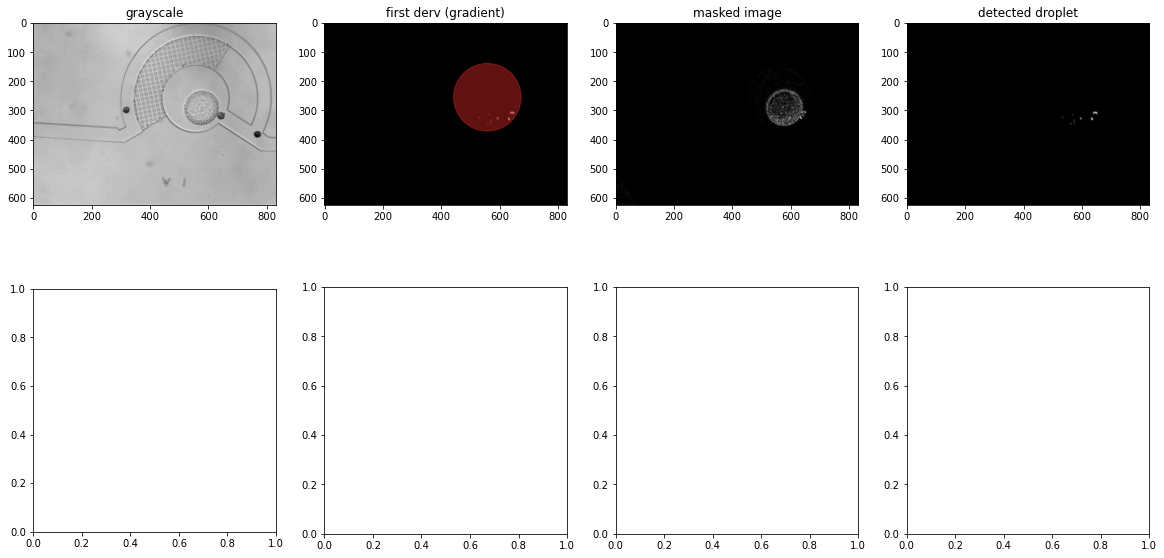

In [5]:
c = 3
w = 0
t = 27


image = time_resolution[t][c][w]['gray'].copy()
img  = time_resolution[t][c][w]['img'].copy() # masked img
grad  = time_resolution[t][c][w]['grad2'].copy()
xd = time_resolution[t][c][w]['droplet data'][0,0]
yd = time_resolution[t][c][w]['droplet data'][0,1]
rd = time_resolution[t][c][w]['droplet data'][0,2]
xw = time_resolution[t][c][w]['x']
yw = time_resolution[t][c][w]['y']
rw = time_resolution[t][c][w]['r']

print("meanlist", time_resolution[0][c][w]['mean list'], "; mean:", np.mean(time_resolution[0][c][w]['mean list']))
print("Areas:", time_resolution[0][c][w]['areas'])
print("starting conc:", starting_concentrations[c])
#print("LLPS conc:", time_resolution[0][c][w]['LLPS conc'])

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

axs[0, 0].imshow(image, cmap="gray")
axs[0,0 ].set_title("grayscale")

axs[0, 1].imshow(grad, cmap="gray")
axs[0, 1].set_title("first derv (gradient)")
circle = plt.Circle((xw, yw), rw, color='tab:red', alpha=0.45)
axs[0, 1].add_patch(circle)

axs[0, 2].imshow(img, cmap="gray")
axs[0, 2].set_title("masked image")

axs[0, 3].imshow(time_resolution[t][c][w]['grad2'], cmap="gray")
axs[0, 3].set_title("detected droplet")
circle = plt.Circle((xd, yd), rd, color='tab:blue', alpha=0.25)
axs[0, 3].add_patch(circle)

axs[1, 0].imshow(time_resolution[t][c][w]['squ'], cmap="gray")
axs[1, 0].set_title("squircle inside detected droplet")
circle = plt.Circle((xd, yd), rd, color='tab:blue', alpha=0.25)
axs[1, 0].add_patch(circle)

axs[1, 1].imshow(time_resolution[t][c][w]['cro squ'], cmap="gray")
axs[1, 1].set_title("cropped squircle")

axs[1, 2].plot(np.arange(len(time_resolution[0][c][w]['mean list'])), time_resolution[0][c][w]['mean list'])
axs[1, 2].scatter(t, time_resolution[0][c][w]['mean list'][t], color='red')

blurrr = cv2.dilate(time_resolution[t][c][w]['cro squ'], (5,5))
print(blurrr.shape[0]*blurrr.shape[0] - np.count_nonzero(blurrr))

In [ ]:
cropped_squircled_pixels = time_resolution[t][c][w]['cro squ']
_, thresh = cv2.threshold(cropped_squircled_pixels, 130, 255, cv2.THRESH_BINARY_INV)
d = cropped_squircled_pixels.shape[0] * 0.54
n = np.sum(thresh) #/ d**2
print(n)

In [ ]:
plt.imshow(thresh)

## Plot the data

In [ ]:
### figure setup ###


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,8), sharex=False, sharey=False)

# set labels
ax1.set_xlabel(f"{name_sol1} [{unit_sol1}]")
ax1.set_ylabel(f"{name_sol2} [{unit_sol2}]")
ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)

ax2.set_xlabel(ax1.get_xlabel())
ax2.xaxis.label.set_size(ax1.xaxis.label.get_size())
ax2.set_ylabel(ax1.get_ylabel())
ax2.yaxis.label.set_size(ax1.yaxis.label.get_size())

# set limits 
xlim = int(initial_conc_sol1 * 4)
ylim = int(initial_conc_sol2 * 5)
ax1.set_xlim(0, xlim)
ax1.set_ylim(0, ylim)
ax2.set_xlim(0, xlim)
ax2.set_ylim(0, ylim)

# set titles
ax1.set_title('individual wells', fontsize=25)
ax2.set_title('means', fontsize= 25)

# set ticks
ax1.tick_params(axis='y', which='major', right=True, color="black", labelcolor="black", direction='out', labelsize=15)
ax1.tick_params(axis='y', which='minor', right=True)
ax1.tick_params(axis='x', which='major', top=True, labeltop=False, direction='out', labelsize=15)
ax1.tick_params(axis='x', which='minor', bottom=True, top=True)
ax1.minorticks_on()
ax1.xaxis.set_major_locator(MultipleLocator(2000))
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_major_locator(MultipleLocator(10))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))
ax1.xaxis.set_tick_params(which='both', width=2)
ax1.yaxis.set_tick_params(which='both', width=2)


ax2.tick_params(axis='y', which='major', right=True, color="black", labelcolor="black", direction='out', labelsize=15)
ax2.tick_params(axis='y', which='minor', right=True)
ax2.tick_params(axis='x', which='major', top=True, labeltop=False, direction='out', labelsize=15)
ax2.tick_params(axis='x', which='minor', bottom=True, top=True)
ax2.minorticks_on()
ax2.xaxis.set_major_locator(MultipleLocator(2000))
ax2.xaxis.set_minor_locator(AutoMinorLocator(2))
ax2.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.xaxis.set_tick_params(which='both', width=2)
ax2.yaxis.set_tick_params(which='both', width=2)


# plot starting concentrations and the data
well_nr = 0

for conc_nr in range (number_of_diff_conc):
        for n_wells_per_horizontal in range(n_wells):
            if time_resolution[0][conc_nr][well_nr]['areas'][0, 0] != 0:
            
                if conc_nr == 0:
                    color = "blue"
                if conc_nr == 1:
                    color = "orange"
                if conc_nr == 2:
                    color = "gray"
                if conc_nr == 3:
                    color = "yellow"
                if conc_nr == 4:
                    color = "green"

                ax1.scatter(starting_concentrations[conc_nr,0], starting_concentrations[conc_nr,1], s=60, c=color, marker="s", edgecolors="black")
                ax1.scatter(time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0],time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,1],
                            s=60, color=color, marker="o", edgecolors="black")
                
            well_nr += 1
        well_nr = 0
well_nr = 0


# calculate and plot mean
mean_sol1 = []
mean_sol1 = [0] * 5
mean_sol2 = []
mean_sol2 = [0] * 5
n_llps_wells = []
n_llps_wells = [0] * 5

for conc_nr in range (number_of_diff_conc):
        for n_wells_per_horizontal in range(n_wells):
            if time_resolution[0][conc_nr][well_nr]['areas'][0, 0] != 0:           
                # calculate mean
                mean_sol1[conc_nr] = mean_sol1[conc_nr] + time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0]
                print(conc_nr, well_nr, time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0])
                mean_sol2[conc_nr] = mean_sol2[conc_nr] + time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,1]
                n_llps_wells[conc_nr] += 1
                
            well_nr += 1
        well_nr = 0
well_nr = 0


for conc_nr in range(number_of_diff_conc):
    if conc_nr == 0:
        color = "blue"
    if conc_nr == 1:
        color = "orange"
    if conc_nr == 2:
        color = "gray"
    if conc_nr == 3:
        color = "yellow"
    if conc_nr == 4:
        color = "green"
    if n_llps_wells[conc_nr] > 0:
        mean_sol1[conc_nr] = mean_sol1[conc_nr]/n_llps_wells[conc_nr]
        mean_sol2[conc_nr] = mean_sol2[conc_nr]/n_llps_wells[conc_nr]
        m = mean_sol2[conc_nr]/mean_sol1[conc_nr]
        
    ax2.plot([0, mean_sol1[conc_nr],xlim], [0, mean_sol2[conc_nr], m*xlim], color=color, linestyle='dashed', alpha=0.50)
    ax2.scatter(starting_concentrations[conc_nr,0], starting_concentrations[conc_nr,1], s=60, c=color, marker="s", edgecolors="black")

    ax2.scatter(mean_sol1[conc_nr],mean_sol2[conc_nr], s=60, color=color,
                           marker="o", edgecolors="black")
 